In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pathlib import Path
import warnings
import psycopg2
import time
from sqlalchemy import create_engine
warnings.filterwarnings('ignore')
import sys
import pickle
from pprint import pprint
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PowerTransformer
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
from scipy.stats import chi2_contingency 
from yellowbrick.classifier import ROCAUC
sys.path.insert(0, os.path.realpath('..\..\src'))
from database.database_config import DB_NAME, DB_HOST, DB_USER, DB_PASSWORD

In [2]:
#testing connecting to database and getting back data
db = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}/{DB_NAME}")
conn = db.connect()

In [3]:
SQL = """
select
	match_id,
	mf.date_id,
	mf.venue_id,
	mf.referee_id,
	home_team_id as home_id,
	away_team_id as away_id,
	attendance,
    match_week,
	xg_home,
	xg_away,
	home_goal,
	away_goal,
	home_captain_name,
	away_captain_name,
	home_formation,
	away_formation,
	home_possession,
	away_possession,
	home_shots,
	home_shots_on_target,
	home_distance,
	home_freekicks,
	home_penalty_kicks,
	home_touches,
	home_touches_att_pen,
	home_touches_def_pen,
	home_touches_def_third,
	home_touches_mid_third,
	home_touches_att_third,
	home_touches_live,
	home_dribbles_success,
	home_dribbles_att,
	home_dribbles_mis,
	home_dribbles_dis,
	home_receiving_rec,
	home_receiving_prog,
	away_shots,
	away_shots_on_target,
	away_distance,
	away_freekicks,
	away_penalty_kicks,
	away_touches,
	away_touches_att_pen,
	away_touches_def_pen,
	away_touches_def_third,
	away_touches_mid_third,
	away_touches_att_third,
	away_touches_live,
	away_dribbles_success,
	away_dribbles_att,
	away_dribbles_mis,
	away_dribbles_dis,
	away_receiving_rec,
	away_receiving_prog,
	match_result,
	ht.team_name as home_team,
	aw.team_name as away_team,
	md."_date_",
	md."_time_" ,
	md."_day_",
	extract(MONTH from md."_date_") AS month,
	extract(DAY from md."_date_") AS day_of_month,
	extract(DOW from md."_date_") AS day_of_week,
	extract(YEAR from md."_date_") AS year,
	extract(HOUR from md."_time_") AS hour,
	extract(MINUTE from md."_time_") AS minute,
    extract(SECOND from md."_time_") AS second,
	mr.referee_name,
	mv.venue_name
from
	laliga_wh.match_facts mf
inner join laliga_wh.match_teams ht 
on
	ht.team_id = mf.home_team_id
inner join laliga_wh.match_teams aw 
on
	aw.team_id = mf.away_team_id
inner join laliga_wh.match_dates md 
on
	md.date_id = mf.date_id
inner join laliga_wh.match_referees mr 
on
	mr.referee_id = mf.referee_id
inner join laliga_wh.match_venues mv 
on
	mv.venue_id = mf.venue_id
"""

In [4]:
match_df = pd.read_sql(SQL, con=conn)
match_df.head()
conn.close()

In [5]:
# Drop id columns
match_results = match_df.iloc[:,6:]

In [6]:
#Cehck the columns quick
# for i,v in match_results.dtypes.iteritems():
#     print(i, v)

In [7]:
match_results[match_results['attendance'].isnull()]

,attendance,match_week,xg_home,xg_away,home_goal,away_goal,home_captain_name,away_captain_name,home_formation,away_formation,...,_day_,month,day_of_month,day_of_week,year,hour,minute,second,referee_name,venue_name
66,NaN,7,4.0,0.7,3,0,Lionel Messi,Jonathan Viera,4-4-2,4-2-3-1,...,Sun,10.0,1.0,0.0,2017.0,16.0,15.0,0.0,José Munuera,Camp Nou
1029,NaN,24,2.0,1.2,1,2,Gonzalo Escalante,Mikel Oyarzabal,4-2-3-1,4-2-3-1,...,Tue,3.0,10.0,2.0,2020.0,20.0,0.0,0.0,David Medié,Estadio Municipal de Ipurúa
1030,NaN,28,1.7,0.5,2,0,Jesús Navas,Sergio Canales,4-3-3,4-3-3,...,Thu,6.0,11.0,4.0,2020.0,22.0,0.0,0.0,Antonio Matéu Lahoz,Estadio Ramón Sánchez Pizjuán
1031,NaN,28,2.3,0.6,2,1,Víctor Díaz,Jorge Molina,4-2-3-1,4-4-2,...,Fri,6.0,12.0,5.0,2020.0,19.0,30.0,0.0,David Medié,Estadio Nuevo Los Cármenes
1032,NaN,28,1.0,1.4,1,1,Daniel Parejo,José Luis Morales,4-4-2,4-4-2,...,Fri,6.0,12.0,5.0,2020.0,22.0,0.0,0.0,Alberola Rojas,Estadio de Mestalla
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,NaN,38,1.2,0.6,2,1,Karim Benzema,Mario Gaspar,4-3-3,4-4-2,...,Sat,5.0,22.0,6.0,2021.0,18.0,0.0,0.0,José Luis Munuera,Estadio Alfredo Di Stéfano
1517,NaN,38,1.1,1.4,1,2,Jordi Masip,Koke,4-4-2,4-3-3,...,Sat,5.0,22.0,6.0,2021.0,18.0,0.0,0.0,José Sánchez,Estadio Municipal José Zorrilla
1518,NaN,38,0.4,0.6,0,0,Germán Sánchez,Djené,5-4-1,4-4-1-1,...,Sun,5.0,23.0,0.0,2021.0,18.0,30.0,0.0,David Medié,Estadio Nuevo Los Cármenes
1519,NaN,38,0.4,1.1,1,0,Sergio Escudero,Manu García,4-3-3,4-3-3,...,Sun,5.0,23.0,0.0,2021.0,21.0,0.0,0.0,Isidro Díaz de Mera,Estadio Ramón Sánchez Pizjuán


In [8]:
# Fix data types for certain columns
match_results['attendance'] = match_results['attendance'].astype(pd.Int64Dtype())
match_results['_date_'] = pd.to_datetime(match_results['_date_'])
# int_columns = match_results.select_dtypes(include=['Int64', 'int64']).columns
# float_columns = match_results.select_dtypes(include=['float64']).columns
# match_results[int_columns] = match_results[int_columns].astype('int64')
# match_results[float_columns] = match_results[float_columns].astype('np.float32')
match_results['month'] = match_results['month'].astype('int64')
match_results['day_of_month'] = match_results['day_of_month'].astype('int64')
match_results['day_of_week'] = match_results['day_of_week'].astype('int64')
match_results['year'] = match_results['year'].astype('int64')
match_results['hour'] = match_results['hour'].astype('int64')
match_results['minute'] = match_results['minute'].astype('int64')
match_results['second'] = match_results['second'].astype('int64')
match_results.drop(['_day_', '_time_'], axis = 1, inplace = True) # Not needed as we created numerical columns for the date components

In [9]:
match_results['home_formation'].value_counts()

4-4-2         695
4-2-3-1       391
4-3-3         347
4-1-4-1       124
3-4-3          84
3-5-2          67
5-3-2          64
4-1-3-2        45
4-4-1-1        44
3-1-4-2        38
4-1-2-1-2◆     32
5-4-1          26
3-4-1-2        16
4-3-1-2        12
4-5-1          11
3-5-1-1         5
4-2-2-2         5
4-3-2-1         2
3-4-3◆          1
4-2-4-0         1
Name: home_formation, dtype: int64

In [10]:
# Clean up formations
match_results['home_formation'] = match_results['home_formation'].replace({'4-4-2◆': '4-4-2', '4-3-1-2◆':'4-3-1-2', '4-3-3◆':'4-3-3', '4-1-3-2◆':'4-1-3-2',
                                         '4-2-3-1◆':'4-2-3-1', '3-4-3◆':'3-4-3', '4-1-2-1-2◆': '4-1-2-1-2'})
match_results['away_formation'] = match_results['away_formation'].replace({'4-4-2◆': '4-4-2', '4-3-1-2◆':'4-3-1-2', '4-3-3◆':'4-3-3', '4-1-3-2◆':'4-1-3-2',
                                         '4-2-3-1◆':'4-2-3-1', '3-4-3◆':'3-4-3', '4-3-2-1◆':'4-3-2-1', '4-1-2-1-2◆': '4-1-2-1-2'})

# Time Frame Extraction
Gather only data up until last season

In [11]:
print('Start Date: ', min(match_results._date_.dt.date))
print('End Date: ', max(match_results._date_.dt.date))

Start Date:  2017-08-18
End Date:  2022-10-24


In [12]:
start_date = '2017-08-01'
end_date = '2022-05-30'
mask = (match_results['_date_'] > start_date) & (match_results['_date_'] <= end_date)
match_results = match_results.loc[mask]

# Preprocessing

In [13]:
# Count number of missing values
for i, v in match_results.isna().sum().iteritems():
    print(i + '\t' + str(v))

attendance	488
match_week	0
xg_home	0
xg_away	0
home_goal	0
away_goal	0
home_captain_name	0
away_captain_name	0
home_formation	0
away_formation	0
home_possession	0
away_possession	0
home_shots	0
home_shots_on_target	0
home_distance	0
home_freekicks	0
home_penalty_kicks	0
home_touches	0
home_touches_att_pen	0
home_touches_def_pen	0
home_touches_def_third	0
home_touches_mid_third	0
home_touches_att_third	0
home_touches_live	0
home_dribbles_success	0
home_dribbles_att	0
home_dribbles_mis	0
home_dribbles_dis	0
home_receiving_rec	0
home_receiving_prog	0
away_shots	0
away_shots_on_target	0
away_distance	2
away_freekicks	0
away_penalty_kicks	0
away_touches	0
away_touches_att_pen	0
away_touches_def_pen	0
away_touches_def_third	0
away_touches_mid_third	0
away_touches_att_third	0
away_touches_live	0
away_dribbles_success	0
away_dribbles_att	0
away_dribbles_mis	0
away_dribbles_dis	0
away_receiving_rec	0
away_receiving_prog	0
match_result	0
home_team	0
away_team	0
_date_	0
month	0
day_of_month	0
d

In [14]:
# Drop attendance. We have MCAR data here and not recommended to keep it
# Drop _date_. We already split this into numerical components
# Fill other columns with 1 or 2 missing values with median
match_results.drop(['attendance', '_date_', 'match_week'], axis = 1, inplace = True)
match_results[ 'away_distance'] = match_results[ 'away_distance'].fillna(match_results['away_distance'].median())
int_columns = match_results.select_dtypes(include=['Int64', 'int64']).columns
match_results[int_columns] = match_results[int_columns].astype('int64')

In [15]:
# Count number of missing values - check again
for i, v in match_results.isna().sum().iteritems():
    print(i + '\t' + str(v))

xg_home	0
xg_away	0
home_goal	0
away_goal	0
home_captain_name	0
away_captain_name	0
home_formation	0
away_formation	0
home_possession	0
away_possession	0
home_shots	0
home_shots_on_target	0
home_distance	0
home_freekicks	0
home_penalty_kicks	0
home_touches	0
home_touches_att_pen	0
home_touches_def_pen	0
home_touches_def_third	0
home_touches_mid_third	0
home_touches_att_third	0
home_touches_live	0
home_dribbles_success	0
home_dribbles_att	0
home_dribbles_mis	0
home_dribbles_dis	0
home_receiving_rec	0
home_receiving_prog	0
away_shots	0
away_shots_on_target	0
away_distance	0
away_freekicks	0
away_penalty_kicks	0
away_touches	0
away_touches_att_pen	0
away_touches_def_pen	0
away_touches_def_third	0
away_touches_mid_third	0
away_touches_att_third	0
away_touches_live	0
away_dribbles_success	0
away_dribbles_att	0
away_dribbles_mis	0
away_dribbles_dis	0
away_receiving_rec	0
away_receiving_prog	0
match_result	0
home_team	0
away_team	0
month	0
day_of_month	0
day_of_week	0
year	0
hour	0
minute	0
s

In [16]:
# One hot encode
match_results_encode = pd.get_dummies(match_results, columns = ['home_captain_name', 'away_captain_name', 'home_formation', 'away_formation',
                                                                'home_team', 'away_team', 'referee_name', 'venue_name'])

In [17]:
match_results_encode.head()

,xg_home,xg_away,home_goal,away_goal,home_possession,away_possession,home_shots,home_shots_on_target,home_distance,home_freekicks,...,venue_name_Estadio Wanda Metropolitano,venue_name_Estadio de Balaídos,venue_name_Estadio de Gran Canaria,venue_name_Estadio de Mendizorroza,venue_name_Estadio de Mestalla,venue_name_Estadio de la Cerámica,venue_name_Estadio del Rayo Vallecano,venue_name_Iberostar Estadi,venue_name_RCDE Stadium,venue_name_San Mamés
0,1.3,1.1,1,0,53.0,47.0,14,3,22.0,2,...,0,0,0,0,0,0,0,0,0,0
1,1.4,0.2,1,0,47.0,53.0,22,6,17.0,2,...,0,0,0,0,1,0,0,0,0,0
2,1.8,2.1,2,3,53.0,47.0,16,5,17.4,1,...,0,1,0,0,0,0,0,0,0,0
3,2.2,0.7,2,2,52.0,48.0,13,6,18.2,1,...,0,0,0,0,0,0,0,0,0,0
4,2.4,1.3,1,1,62.0,38.0,9,4,11.5,0,...,0,0,0,0,0,0,0,0,0,0


# Explore the Data

## Check match results

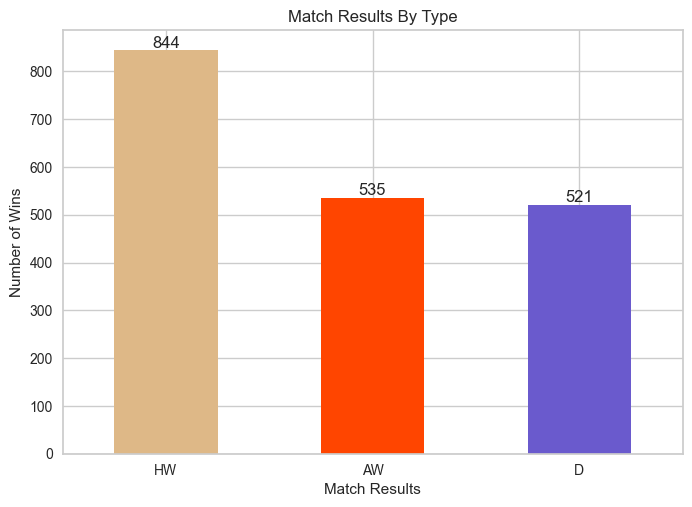

In [18]:
ax = match_results_encode['match_result'].value_counts().plot(kind = 'bar', color = ['burlywood', 'orangered', 'slateblue'], rot =0, 
                                                              xlabel = "Match Results", ylabel = "Number of Wins", title = "Match Results By Type")
ax.plot()
ax.bar_label(ax.containers[0])
plt.show()

We see that there are a high number of away wins. There is possibly a home field advantage present in our data

## Check El Clasico match results

In [19]:
# get all records with El Clasico
clasico_matches = match_results_encode[((match_results_encode['home_team_Barcelona'] == 1) & (match_results_encode['away_team_Real Madrid'] == 1)) |
                                       ((match_results_encode['home_team_Real Madrid'] == 1) & (match_results_encode['away_team_Barcelona'] == 1))]

In [20]:
#Encode the match results
def create_clasico_result(row):
    if row.match_result == 'HW' and row['home_team_Barcelona'] == 1:
        return 'Barcelona Win'
    elif row.match_result == 'AW' and row['away_team_Barcelona'] == 1:
        return 'Barcelona Win'
    elif row.match_result == 'HW' and row['home_team_Real Madrid'] == 1:
        return 'Real Madrid Win'
    elif row.match_result == 'AW' and row['away_team_Real Madrid'] == 1:
        return 'Real Madrid Win'
    else:
        return 'Draw'
    
clasico_matches['clasico_result'] = clasico_matches.apply(create_clasico_result, axis =1)

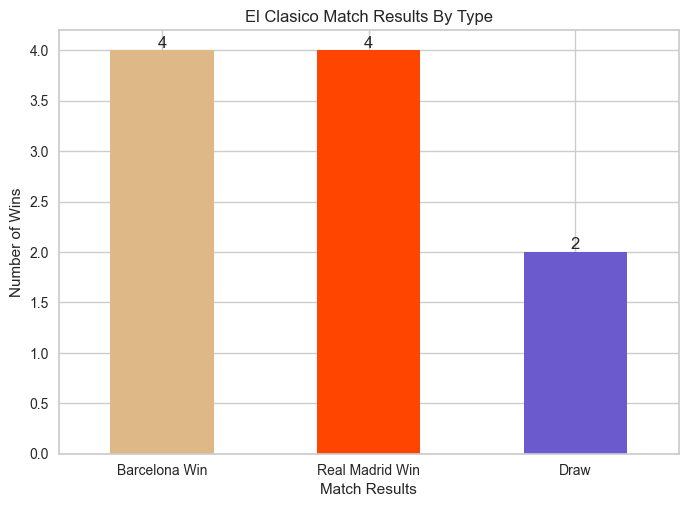

In [21]:
ax = clasico_matches['clasico_result'].value_counts().plot(kind = 'bar', color = ['burlywood', 'orangered', 'slateblue'], rot = 0,
                                                          xlabel = "Match Results", ylabel = "Number of Wins", title = "El Clasico Match Results By Type")
ax.plot()
ax.bar_label(ax.containers[0])
plt.show()

We see here that matches are fairly even between FC Barcelona and Real Madrid the past 4 seasons

## Check our numerical distributions

In [22]:
#Select all our numerical columns
numerical_columns = match_results_encode.select_dtypes(include=['Int64', 'int64', 'float64', 'int32'])

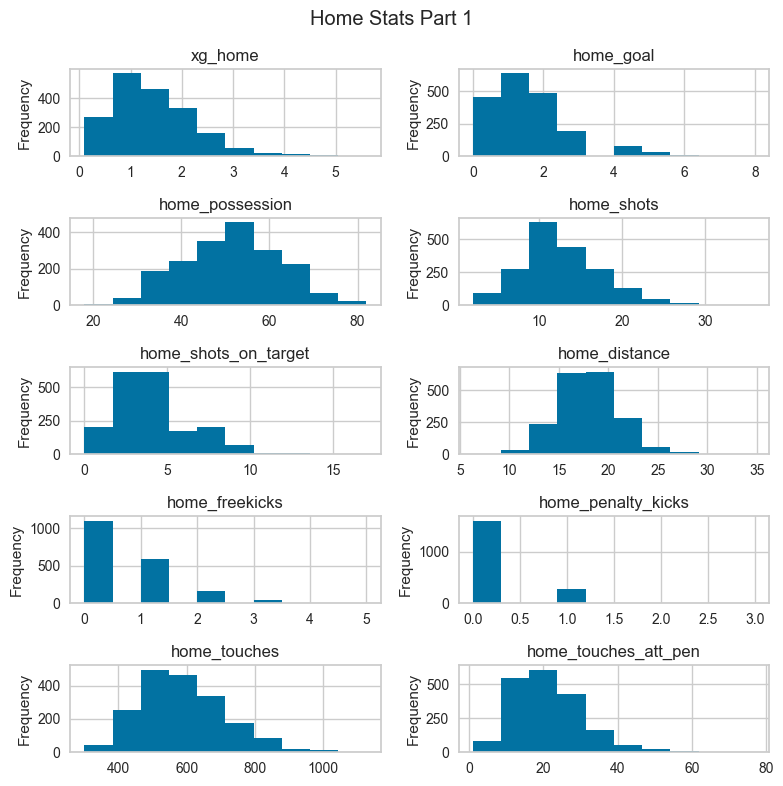

In [23]:
fig1, ax1 = plt.subplots(nrows=5, ncols= 2,figsize=(8, 8))
numerical_columns['xg_home'].plot.hist(ax =ax1[0,0], title = 'xg_home')
numerical_columns['home_goal'].plot.hist(ax =ax1[0,1], title = 'home_goal')
numerical_columns['home_possession'].plot.hist(ax =ax1[1,0], title = 'home_possession')
numerical_columns['home_shots'].plot.hist(ax =ax1[1,1], title = 'home_shots')
numerical_columns['home_shots_on_target'].plot.hist(ax =ax1[2,0], title = 'home_shots_on_target')
numerical_columns['home_distance'].plot.hist(ax =ax1[2,1], title = 'home_distance')
numerical_columns['home_freekicks'].plot.hist(ax =ax1[3,0], title = 'home_freekicks')
numerical_columns['home_penalty_kicks'].plot.hist(ax =ax1[3,1], title = 'home_penalty_kicks')
numerical_columns['home_touches'].plot.hist(ax =ax1[4,0], title = 'home_touches')
numerical_columns['home_touches_att_pen'].plot.hist(ax =ax1[4,1], title = 'home_touches_att_pen')

plt.suptitle('Home Stats Part 1')
plt.tight_layout()
plt.show()

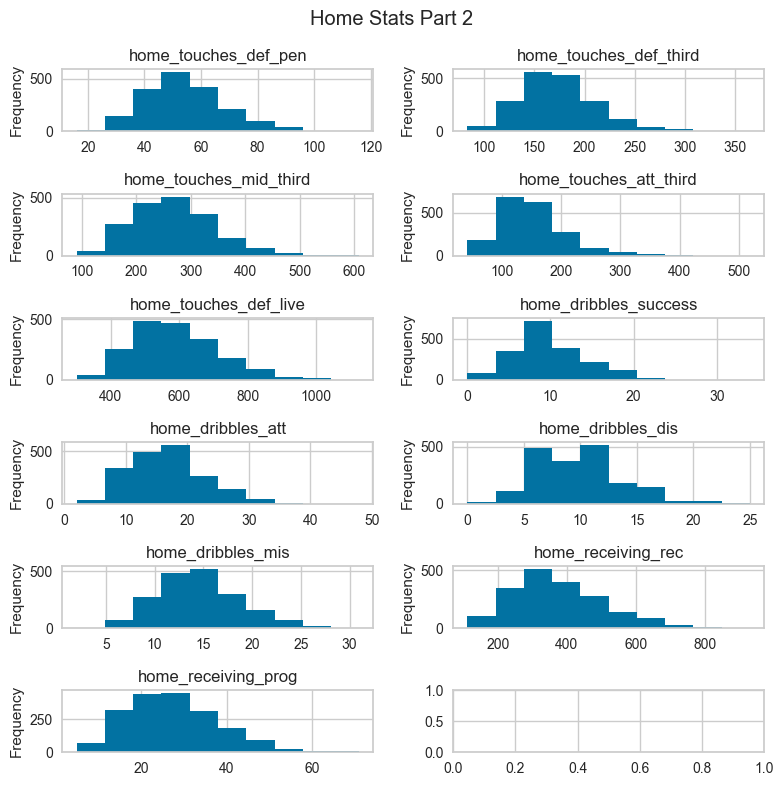

In [24]:
fig2, ax2 = plt.subplots(nrows=6, ncols= 2,figsize=(8, 8))
numerical_columns['home_touches_def_pen'].plot.hist(ax =ax2[0,0], title = 'home_touches_def_pen')
numerical_columns['home_touches_def_third'].plot.hist(ax =ax2[0,1], title = 'home_touches_def_third')
numerical_columns['home_touches_mid_third'].plot.hist(ax =ax2[1,0], title = 'home_touches_mid_third')
numerical_columns['home_touches_att_third'].plot.hist(ax =ax2[1,1], title = 'home_touches_att_third')
numerical_columns['home_touches_live'].plot.hist(ax =ax2[2,0], title = 'home_touches_def_live')
numerical_columns['home_dribbles_success'].plot.hist(ax =ax2[2,1], title = 'home_dribbles_success')
numerical_columns['home_dribbles_att'].plot.hist(ax =ax2[3,0], title = 'home_dribbles_att')
numerical_columns['home_dribbles_dis'].plot.hist(ax =ax2[3,1], title = 'home_dribbles_dis')
numerical_columns['home_dribbles_mis'].plot.hist(ax =ax2[4,0], title = 'home_dribbles_mis')
numerical_columns['home_receiving_rec'].plot.hist(ax =ax2[4,1], title = 'home_receiving_rec')
numerical_columns['home_receiving_prog'].plot.hist(ax =ax2[5,0], title = 'home_receiving_prog')

plt.suptitle('Home Stats Part 2')
plt.tight_layout()
plt.show()

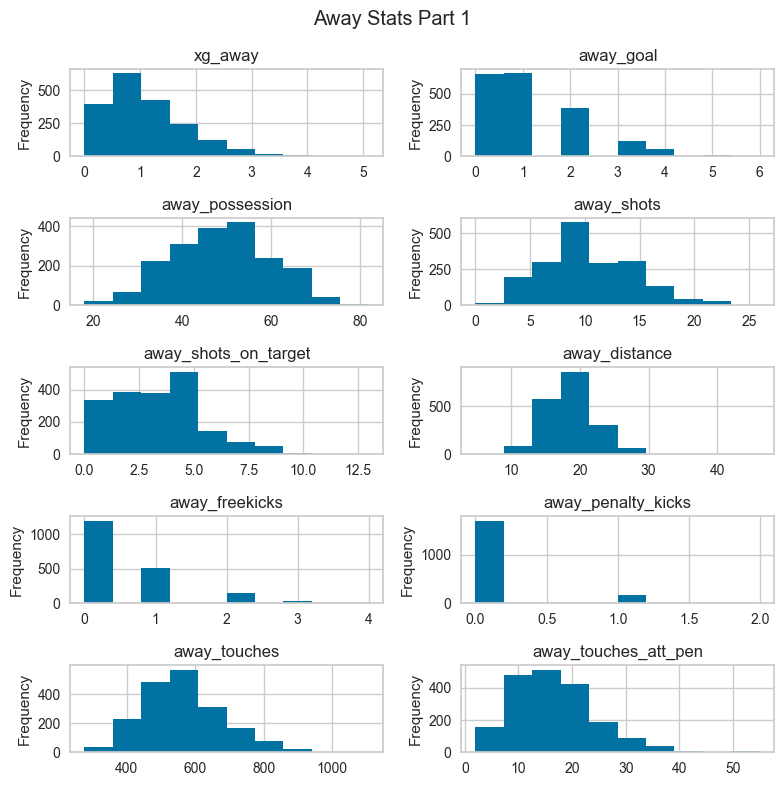

In [25]:
fig1, ax1 = plt.subplots(nrows=5, ncols= 2,figsize=(8, 8))
numerical_columns['xg_away'].plot.hist(ax =ax1[0,0], title = 'xg_away')
numerical_columns['away_goal'].plot.hist(ax =ax1[0,1], title = 'away_goal')
numerical_columns['away_possession'].plot.hist(ax =ax1[1,0], title = 'away_possession')
numerical_columns['away_shots'].plot.hist(ax =ax1[1,1], title = 'away_shots')
numerical_columns['away_shots_on_target'].plot.hist(ax =ax1[2,0], title = 'away_shots_on_target')
numerical_columns['away_distance'].plot.hist(ax =ax1[2,1], title = 'away_distance')
numerical_columns['away_freekicks'].plot.hist(ax =ax1[3,0], title = 'away_freekicks')
numerical_columns['away_penalty_kicks'].plot.hist(ax =ax1[3,1], title = 'away_penalty_kicks')
numerical_columns['away_touches'].plot.hist(ax =ax1[4,0], title = 'away_touches')
numerical_columns['away_touches_att_pen'].plot.hist(ax =ax1[4,1], title = 'away_touches_att_pen')

plt.suptitle('Away Stats Part 1')
plt.tight_layout()
plt.show()

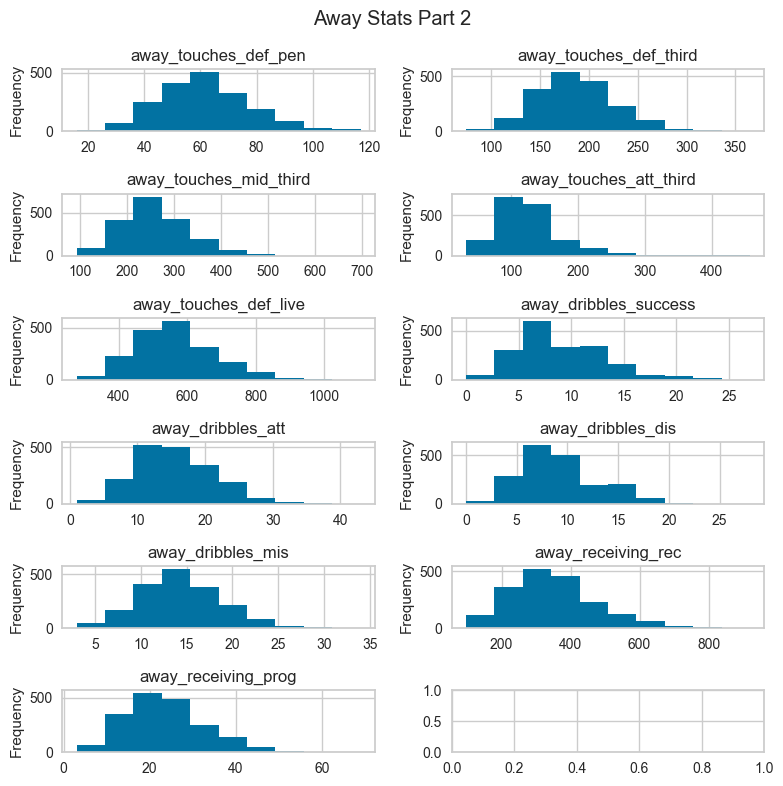

In [26]:
fig2, ax2 = plt.subplots(nrows=6, ncols= 2,figsize=(8, 8))
numerical_columns['away_touches_def_pen'].plot.hist(ax =ax2[0,0], title = 'away_touches_def_pen')
numerical_columns['away_touches_def_third'].plot.hist(ax =ax2[0,1], title = 'away_touches_def_third')
numerical_columns['away_touches_mid_third'].plot.hist(ax =ax2[1,0], title = 'away_touches_mid_third')
numerical_columns['away_touches_att_third'].plot.hist(ax =ax2[1,1], title = 'away_touches_att_third')
numerical_columns['away_touches_live'].plot.hist(ax =ax2[2,0], title = 'away_touches_def_live')
numerical_columns['away_dribbles_success'].plot.hist(ax =ax2[2,1], title = 'away_dribbles_success')
numerical_columns['away_dribbles_att'].plot.hist(ax =ax2[3,0], title = 'away_dribbles_att')
numerical_columns['away_dribbles_dis'].plot.hist(ax =ax2[3,1], title = 'away_dribbles_dis')
numerical_columns['away_dribbles_mis'].plot.hist(ax =ax2[4,0], title = 'away_dribbles_mis')
numerical_columns['away_receiving_rec'].plot.hist(ax =ax2[4,1], title = 'away_receiving_rec')
numerical_columns['away_receiving_prog'].plot.hist(ax =ax2[5,0], title = 'away_receiving_prog')

plt.suptitle('Away Stats Part 2')
plt.tight_layout()
plt.show()

Some of our numerical columns appear to have some skewed distributions. Potentially transforming them may help

In [27]:
#Check correlation
match_results_encode.columns.get_loc('match_result')

42

In [28]:
match_results_encode['match_result'][:15]

0     HW
1     HW
2     AW
3      D
4      D
5      D
6     HW
7     AW
8     HW
9     AW
10    HW
11    HW
12    AW
13    HW
14     D
Name: match_result, dtype: object

In [29]:
# Doing quick encoding 
match_correlation_df = match_results_encode.copy() 
match_correlation_df['match_result'] = match_correlation_df['match_result'].map({'D':0, 'HW':1, 'AW':2})
match_correlation_df['match_result'][:15]

0     1
1     1
2     2
3     0
4     0
5     0
6     1
7     2
8     1
9     2
10    1
11    1
12    2
13    1
14    0
Name: match_result, dtype: int64

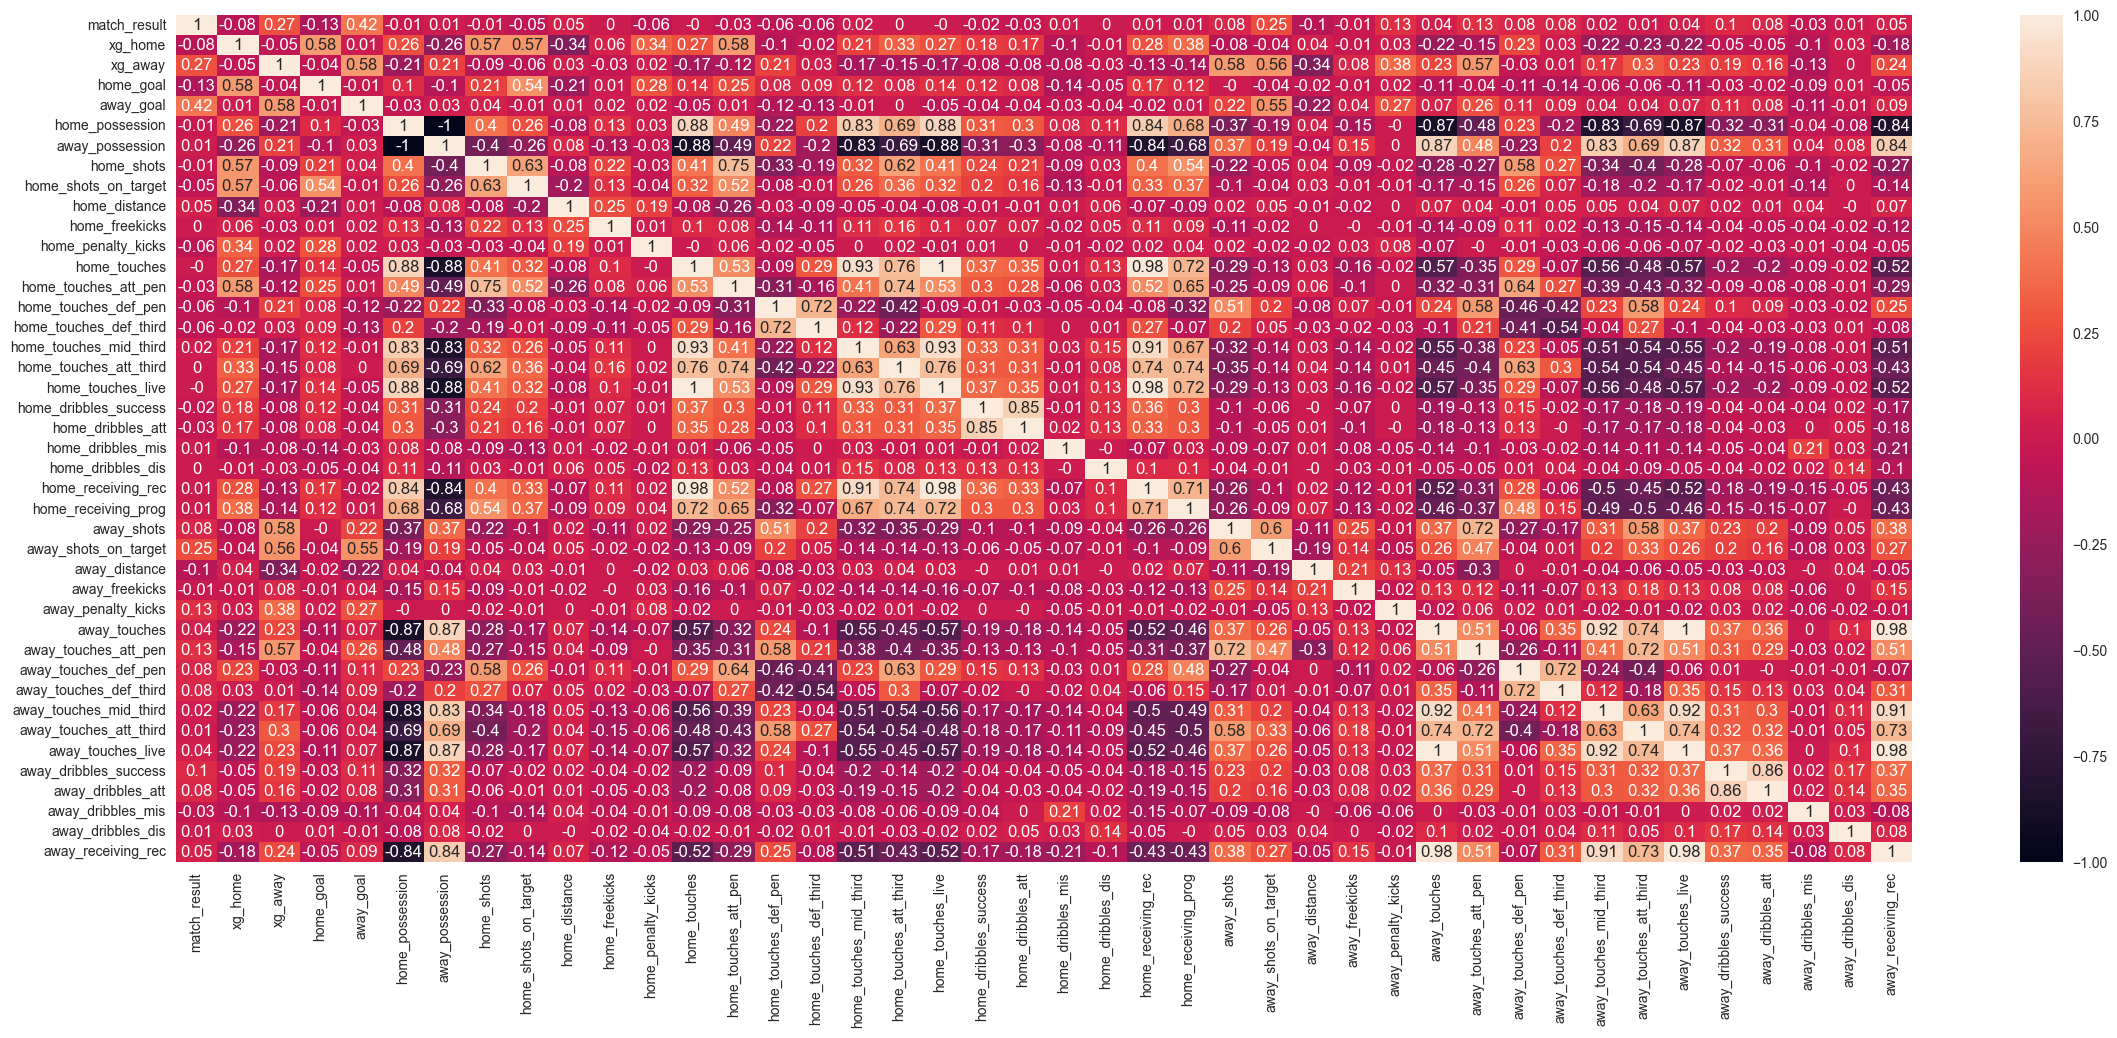

In [30]:
X1 = match_correlation_df.iloc[:,np.r_[42, 0:41]]
corrmatrix1 = X1.corr().round(2)
plt.figure(figsize = (28,11))
sns.heatmap(corrmatrix1, annot = True)
plt.show()

In [31]:
#Chi square test
category_cols = match_results_encode.select_dtypes(include=['object', 'uint8'])

In [32]:
category_cols

,match_result,home_captain_name_Aday,home_captain_name_Adri Embarba,home_captain_name_Adrián López,home_captain_name_Aitor Fernández,home_captain_name_Alberto Cifuentes,home_captain_name_Alberto García,home_captain_name_Alexander,home_captain_name_Alexis,home_captain_name_Alfonso Espino,...,venue_name_Estadio Wanda Metropolitano,venue_name_Estadio de Balaídos,venue_name_Estadio de Gran Canaria,venue_name_Estadio de Mendizorroza,venue_name_Estadio de Mestalla,venue_name_Estadio de la Cerámica,venue_name_Estadio del Rayo Vallecano,venue_name_Iberostar Estadi,venue_name_RCDE Stadium,venue_name_San Mamés
0,HW,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HW,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,AW,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,D,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,D,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895,D,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1896,AW,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1897,AW,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1898,AW,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
probs = []
for feature in category_cols:
    # print(feature)
    contingency = pd.crosstab(category_cols['match_result'], category_cols[feature])
    c, p, dof, expected = chi2_contingency(contingency)
    probs.append(f"match_result vs {feature}: {p}")
pprint(probs)

['match_result vs match_result: 0.0',
 'match_result vs home_captain_name_Aday: 0.6369134266334243',
 'match_result vs home_captain_name_Adri Embarba: 0.8382775431872875',
 'match_result vs home_captain_name_Adrián López: 0.15721978943504425',
 'match_result vs home_captain_name_Aitor Fernández: 0.2790476537736183',
 'match_result vs home_captain_name_Alberto Cifuentes: 0.2790476537736183',
 'match_result vs home_captain_name_Alberto García: 0.37338397883153845',
 'match_result vs home_captain_name_Alexander: 0.9277233160119299',
 'match_result vs home_captain_name_Alexis: 0.2790476537736183',
 'match_result vs home_captain_name_Alfonso Espino: 0.8604660273189545',
 'match_result vs home_captain_name_Ander Capa: 0.2790476537736183',
 'match_result vs home_captain_name_Ander Iturraspe: 0.22815272630486078',
 'match_result vs home_captain_name_Andrés Guardado: 0.16741736278092886',
 'match_result vs home_captain_name_Andrés Iniesta: 0.01036852441336306',
 'match_result vs home_captain_na

# Data Preparation

In [34]:
match_results_clean = match_results_encode.copy()

In [35]:
num_columns = numerical_columns.loc[:, :"away_receiving_prog"]

In [36]:
num_columns.columns

Index(['xg_home', 'xg_away', 'home_goal', 'away_goal', 'home_possession',
       'away_possession', 'home_shots', 'home_shots_on_target',
       'home_distance', 'home_freekicks', 'home_penalty_kicks', 'home_touches',
       'home_touches_att_pen', 'home_touches_def_pen',
       'home_touches_def_third', 'home_touches_mid_third',
       'home_touches_att_third', 'home_touches_live', 'home_dribbles_success',
       'home_dribbles_att', 'home_dribbles_mis', 'home_dribbles_dis',
       'home_receiving_rec', 'home_receiving_prog', 'away_shots',
       'away_shots_on_target', 'away_distance', 'away_freekicks',
       'away_penalty_kicks', 'away_touches', 'away_touches_att_pen',
       'away_touches_def_pen', 'away_touches_def_third',
       'away_touches_mid_third', 'away_touches_att_third', 'away_touches_live',
       'away_dribbles_success', 'away_dribbles_att', 'away_dribbles_mis',
       'away_dribbles_dis', 'away_receiving_rec', 'away_receiving_prog'],
      dtype='object')

In [37]:
scaler = MinMaxScaler()
match_results_clean[num_columns.columns] = scaler.fit_transform(match_results_clean[num_columns.columns])

In [38]:
pt = PowerTransformer()
match_results_clean[num_columns.columns] = pt.fit_transform(match_results_clean[num_columns.columns])

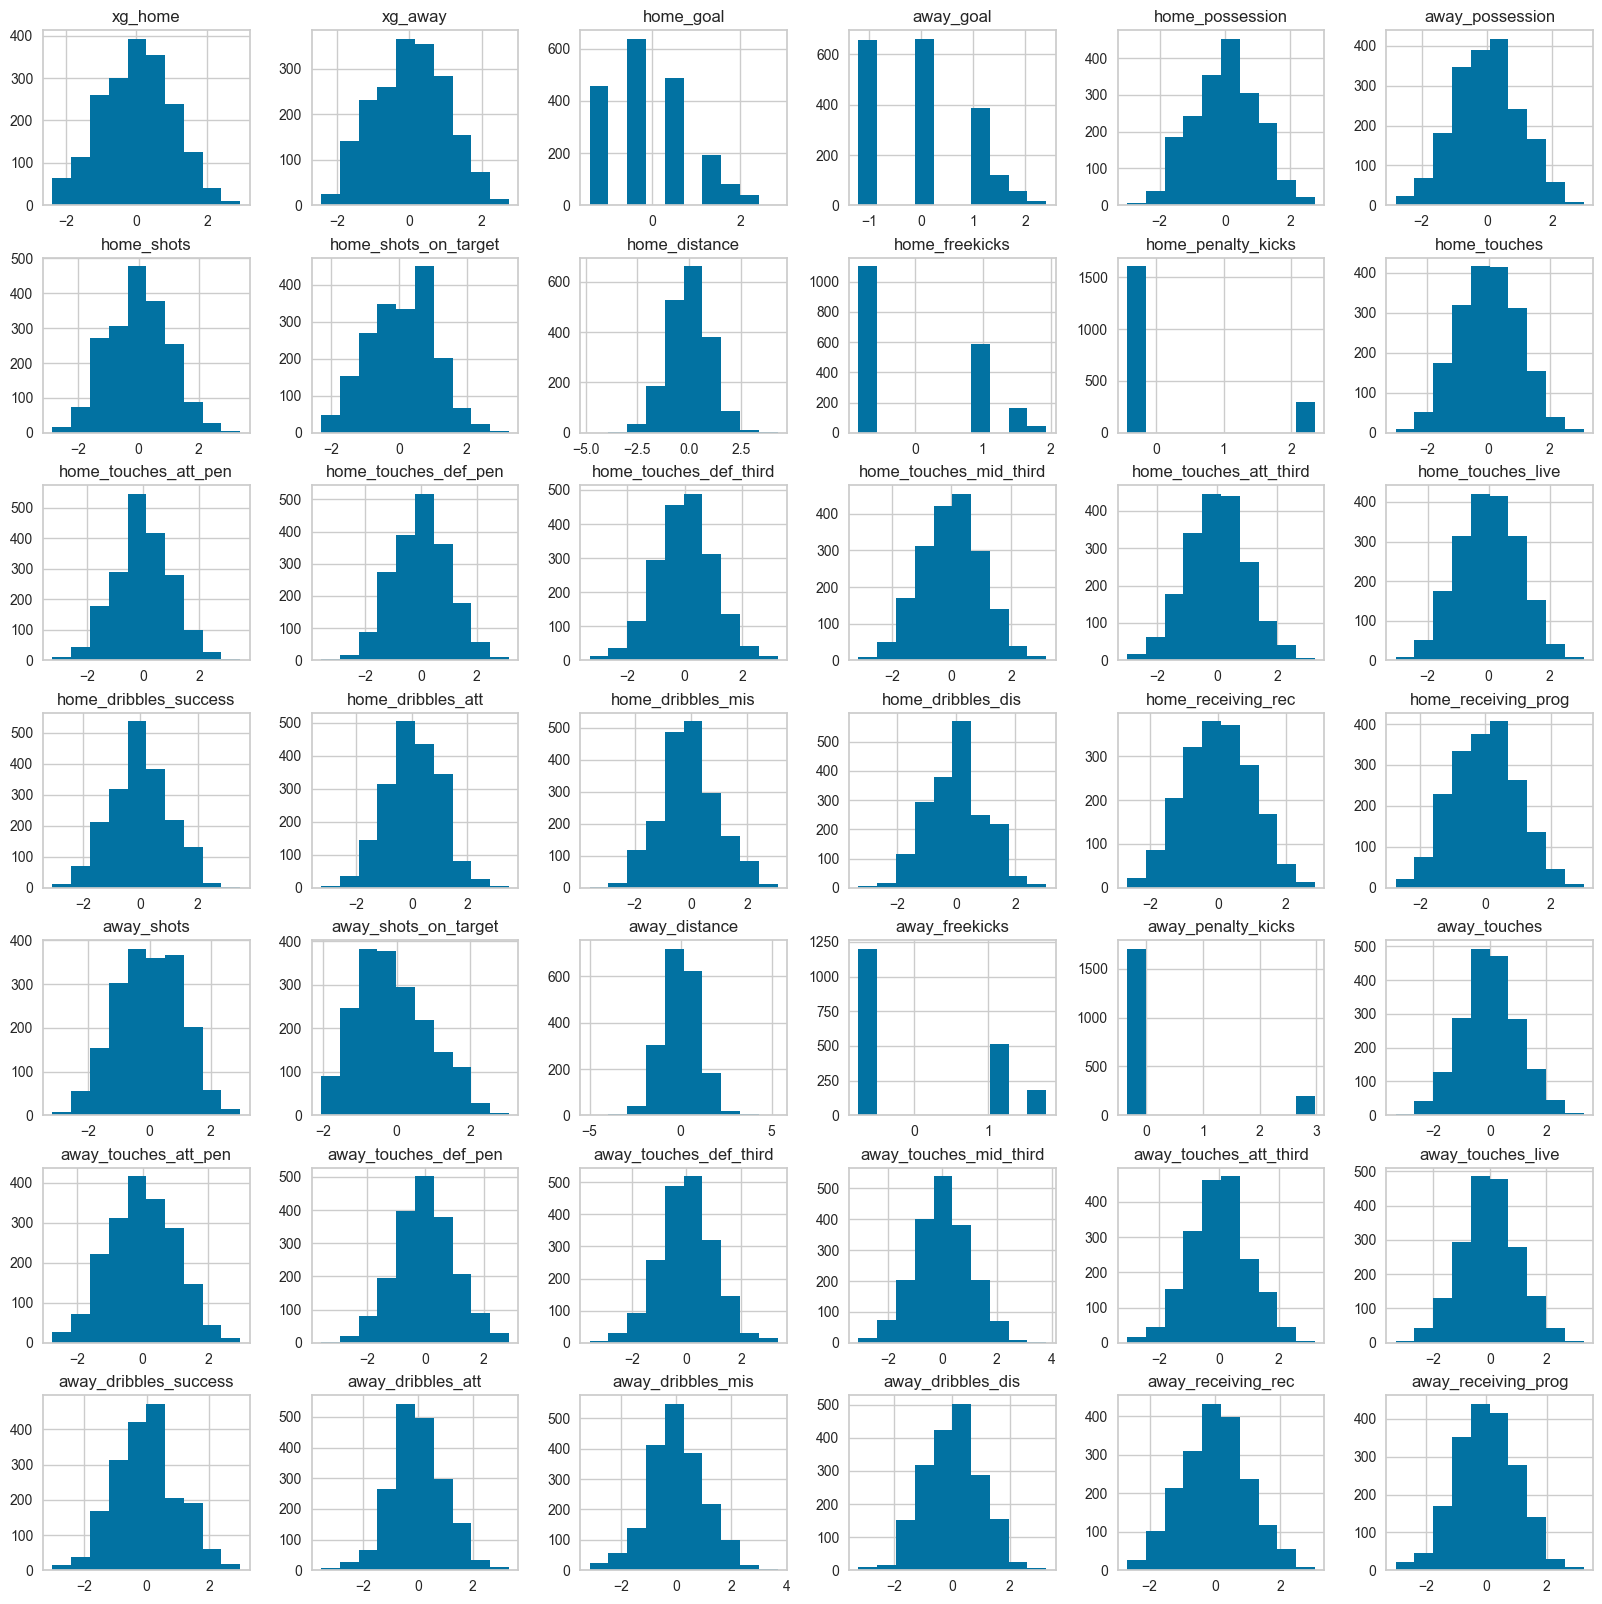

In [39]:
match_results_clean[num_columns.columns].hist(figsize=(20,20))
plt.show()

# Baseline Modeling

In [40]:
#Drop home_goal, away_goal, xg_home, and xg_away
X = match_results_encode.drop(['match_result', 'home_goal', 'away_goal', 'xg_home', 'xg_away'], axis =1)
y = match_results_encode['match_result']

In [41]:
#Have to map this for xgboost
y = y.map({"D" : 0, "HW": 1, "AW":2})

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 68)

## Decision Tree Classifier Baseline

In [43]:
clf = DecisionTreeClassifier(random_state = 67)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=67)

In [44]:
y_pred = clf.predict(X_test)

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.35      0.38        99
           1       0.59      0.67      0.62       171
           2       0.54      0.49      0.51       110

    accuracy                           0.53       380
   macro avg       0.51      0.50      0.51       380
weighted avg       0.53      0.53      0.53       380



In [46]:
print(confusion_matrix(y_test, y_pred))

[[ 35  45  19]
 [ 30 114  27]
 [ 21  35  54]]


In [47]:
accuracy_score(y_test, y_pred)

0.5342105263157895

## SVC Baseline

In [48]:
svc = SVC(random_state=5)

In [49]:
svc.fit(X_train, y_train)

SVC(random_state=5)

In [50]:
y_pred = svc.predict(X_test)

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        99
           1       0.45      1.00      0.62       171
           2       0.00      0.00      0.00       110

    accuracy                           0.45       380
   macro avg       0.15      0.33      0.21       380
weighted avg       0.20      0.45      0.28       380



In [52]:
print(confusion_matrix(y_test, y_pred))

[[  0  99   0]
 [  0 171   0]
 [  0 110   0]]


In [53]:
accuracy_score(y_test, y_pred)

0.45

## RandomForest

In [54]:
rfc = RandomForestClassifier(random_state=5)

In [55]:
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=5)

In [56]:
y_pred = rfc.predict(X_test)

In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.12      0.18        99
           1       0.55      0.85      0.67       171
           2       0.58      0.45      0.50       110

    accuracy                           0.54       380
   macro avg       0.50      0.47      0.45       380
weighted avg       0.51      0.54      0.49       380



In [58]:
print(confusion_matrix(y_test, y_pred))

[[ 12  68  19]
 [  9 145  17]
 [ 11  50  49]]


In [59]:
accuracy_score(y_test, y_pred)

0.5421052631578948

## XgBoostClassifer

In [60]:
xgb_cls = xgb.XGBClassifier(random_state = 5, n_jobs = 6)

In [61]:
xgb_cls.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=6, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [62]:
y_pred = xgb_cls.predict(X_test)

In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.39      0.29      0.34        99
           1       0.66      0.74      0.70       171
           2       0.61      0.63      0.62       110

    accuracy                           0.59       380
   macro avg       0.55      0.55      0.55       380
weighted avg       0.57      0.59      0.58       380



In [64]:
print(confusion_matrix(y_test, y_pred))

[[ 29  49  21]
 [ 20 127  24]
 [ 25  16  69]]


In [65]:
accuracy_score(y_test, y_pred)

0.5921052631578947

## AdaBoostClassifier

In [66]:
ada = AdaBoostClassifier(random_state=5)

In [67]:
ada.fit(X_train, y_train)

AdaBoostClassifier(random_state=5)

In [68]:
y_pred = ada.predict(X_test)

In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.38      0.38        99
           1       0.69      0.73      0.71       171
           2       0.60      0.54      0.56       110

    accuracy                           0.58       380
   macro avg       0.56      0.55      0.55       380
weighted avg       0.58      0.58      0.58       380



In [70]:
print(confusion_matrix(y_test, y_pred))

[[ 38  38  23]
 [ 29 125  17]
 [ 34  17  59]]


In [71]:
accuracy_score(y_test, y_pred)

0.5842105263157895

## Gradient Boosting

In [72]:
grad_boost = GradientBoostingClassifier(random_state=5)

In [73]:
grad_boost.fit(X_train, y_train)

GradientBoostingClassifier(random_state=5)

In [74]:
y_pred = grad_boost.predict(X_test)

In [75]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.32      0.38        99
           1       0.66      0.74      0.70       171
           2       0.57      0.61      0.59       110

    accuracy                           0.59       380
   macro avg       0.56      0.56      0.56       380
weighted avg       0.58      0.59      0.58       380



In [76]:
print(confusion_matrix(y_test, y_pred))

[[ 32  39  28]
 [ 21 127  23]
 [ 18  25  67]]


In [77]:
accuracy_score(y_test, y_pred)

0.5947368421052631

# Tune the models

## RandomForest

In [78]:
rfc.get_params() # Random Forest

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 5,
 'verbose': 0,
 'warm_start': False}

In [79]:
params_rf = {
    "n_estimators": [350, 375, 400,425,450],
    "criterion": ["gini", "entropy",],
    "max_features" : [None, 100, 200, 300, 400, 500],
    # "min_samples_split" :[3,4,5],
    # "min_samples_leaf": [2,3,4],
    # "max_leaf_nodes" : [5, 8, 10, 12],

}

In [80]:
# {'criterion': 'entropy', 'max_features': 520, 'n_estimators': 400} - 60% accuracy

clf_rf_tuned = HalvingGridSearchCV(
    estimator = rfc,
    param_grid=params_rf,
    cv = 5,
    n_jobs = 6,
    verbose = 6
)

In [81]:
start = time.time()
clf_rf_tuned.fit(X_train, y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 56
max_resources_: 1520
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 60
n_resources: 56
Fitting 5 folds for each of 60 candidates, totalling 300 fits
----------
iter: 1
n_candidates: 20
n_resources: 168
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 2
n_candidates: 7
n_resources: 504
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 3
n_candidates: 3
n_resources: 1512
Fitting 5 folds for each of 3 candidates, totalling 15 fits


HalvingGridSearchCV(estimator=RandomForestClassifier(random_state=5), n_jobs=6,
                    param_grid={'criterion': ['gini', 'entropy'],
                                'max_features': [None, 100, 200, 300, 400, 500],
                                'n_estimators': [350, 375, 400, 425, 450]},
                    verbose=6)

In [82]:
end = time.time()
print(f"Time taken to run: {end - start} seconds")

Time taken to run: 472.1904866695404 seconds


In [83]:
clf_rf_tuned.best_params_

{'criterion': 'entropy', 'max_features': 400, 'n_estimators': 350}

In [84]:
y_pred = clf_rf_tuned.predict(X_test)

In [85]:
confusion_matrix(y_test, y_pred)

array([[ 19,  47,  33],
       [ 11, 137,  23],
       [ 16,  29,  65]], dtype=int64)

In [86]:
print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           0       0.41      0.19      0.26        99
           1       0.64      0.80      0.71       171
           2       0.54      0.59      0.56       110

    accuracy                           0.58       380
   macro avg       0.53      0.53      0.51       380
weighted avg       0.55      0.58      0.55       380



In [87]:
print(accuracy_score(y_test, y_pred))

0.5815789473684211


## Gradient Boosting tuned

In [88]:
grad_boost.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 5,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [89]:
params_gb = {
    "learning_rate": [0.075, 0.08, 0.085, 0.1],
    "n_estimators": [300, 350,400, 450,500],
    # "max_features": [None, 100, 200, 300, 400, 500, 546],
    "max_depth" : [4,6,7,8],
}

In [90]:
# {'learning_rate': 0.08, - 60.7% accuracy
#  'max_depth': 3,
#  'max_features': 500,
#  'n_estimators': 200}

clf_gb_tuned = HalvingGridSearchCV(
    estimator = grad_boost,
    param_grid=params_gb,
    cv = 5,
    n_jobs = 6,
    verbose = 6
)

In [91]:
start = time.time()
clf_gb_tuned.fit(X_train, y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 56
max_resources_: 1520
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 80
n_resources: 56
Fitting 5 folds for each of 80 candidates, totalling 400 fits
----------
iter: 1
n_candidates: 27
n_resources: 168
Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------
iter: 2
n_candidates: 9
n_resources: 504
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 3
n_candidates: 3
n_resources: 1512
Fitting 5 folds for each of 3 candidates, totalling 15 fits


HalvingGridSearchCV(estimator=GradientBoostingClassifier(random_state=5),
                    n_jobs=6,
                    param_grid={'learning_rate': [0.075, 0.08, 0.085, 0.1],
                                'max_depth': [4, 6, 7, 8],
                                'n_estimators': [300, 350, 400, 450, 500]},
                    verbose=6)

In [92]:
end = time.time()
print(f"Time taken to run: {end - start} seconds")

Time taken to run: 1592.9443123340607 seconds


In [93]:
clf_gb_tuned.best_params_

{'learning_rate': 0.075, 'max_depth': 8, 'n_estimators': 450}

In [94]:
y_pred = clf_gb_tuned.predict(X_test)

In [95]:
print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           0       0.42      0.32      0.36        99
           1       0.63      0.72      0.67       171
           2       0.59      0.58      0.59       110

    accuracy                           0.58       380
   macro avg       0.55      0.54      0.54       380
weighted avg       0.56      0.58      0.57       380



In [96]:
print(confusion_matrix(y_test,y_pred)) 

[[ 32  45  22]
 [ 26 123  22]
 [ 19  27  64]]


In [97]:
print(accuracy_score(y_test, y_pred))

0.5763157894736842


## XgBoost Classifier Tuned

In [98]:
xgb_cls.get_params()

{'objective': 'multi:softprob',
 'use_label_encoder': None,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 6,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 5,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [99]:
params_xgb = {
     "n_estimators": [190,200, 210, 225, 235, 250],
    "learning_rate" : [0.05, 0.053, 0.055],
    "max_depth" : [None, 3,4,5,6],
    
}

In [100]:
# {'learning_rate': 0.05, 'max_depth': None, 'n_estimators': 200} - 62.6% accuracy

clf_xgb_tuned = HalvingGridSearchCV(
    estimator = xgb_cls,
    param_grid=params_xgb,
    cv = 5,
    n_jobs = 6,
    verbose = 10
)

In [101]:
start = time.time()

clf_xgb_tuned.fit(X_train, y_train)

n_iterations: 4
n_required_iterations: 5
n_possible_iterations: 4
min_resources_: 30
max_resources_: 1520
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 90
n_resources: 30
Fitting 5 folds for each of 90 candidates, totalling 450 fits
----------
iter: 1
n_candidates: 30
n_resources: 90
Fitting 5 folds for each of 30 candidates, totalling 150 fits
----------
iter: 2
n_candidates: 10
n_resources: 270
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 3
n_candidates: 4
n_resources: 810
Fitting 5 folds for each of 4 candidates, totalling 20 fits


HalvingGridSearchCV(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.3000000...
                                            max_cat_to_onehot=4,
                                            max_delta_step=0, max_depth=6,
                                            max_leaves=0, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=6,
                                            num_parallel_tree=1,
                                            objective='multi:softprob',
                                            predictor='auto', ...),
                    n_jobs=6,
                    param_grid={'learning_rate': [0.05, 0.053, 0.055],
                                'max_depth': [None, 3, 4, 5, 6],
                                'n_estimators': [190, 200, 210, 225, 235, 250]},
                    verbose=10)

In [102]:
end = time.time()
print(f"Time taken to run: {end - start} seconds")

Time taken to run: 573.6288087368011 seconds


In [103]:
clf_xgb_tuned.best_params_

{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 250}

In [104]:
y_pred = clf_xgb_tuned.predict(X_test)

In [105]:
print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           0       0.49      0.37      0.42        99
           1       0.67      0.75      0.71       171
           2       0.62      0.64      0.63       110

    accuracy                           0.62       380
   macro avg       0.59      0.59      0.59       380
weighted avg       0.61      0.62      0.61       380



In [106]:
confusion_matrix(y_test, y_pred)

array([[ 37,  41,  21],
       [ 21, 128,  22],
       [ 18,  22,  70]], dtype=int64)

In [107]:
print(accuracy_score(y_test, y_pred))

0.618421052631579


## AdaBoost Tuned

In [108]:
ada.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 5}

In [109]:
params_ada = {
    "algorithm" : ["SAMME.R", "SAMME"],
    "n_estimators": [50, 75, 100],
    "learning_rate":[0.01, 0.05, 0.075, 0.1, 1]
}

In [110]:
# {'algorithm': 'SAMME', 'learning_rate': 0.5, 'n_estimators': 80} - 57.8% accuracy

ada_tuned = HalvingGridSearchCV(
    estimator = ada,
    param_grid = params_ada,
    cv = 5,
    n_jobs = 6,
    verbose = 10
)

In [111]:
start = time.time()
ada_tuned.fit(X_train, y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 56
max_resources_: 1520
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 30
n_resources: 56
Fitting 5 folds for each of 30 candidates, totalling 150 fits
----------
iter: 1
n_candidates: 10
n_resources: 168
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 2
n_candidates: 4
n_resources: 504
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 3
n_candidates: 2
n_resources: 1512
Fitting 5 folds for each of 2 candidates, totalling 10 fits


HalvingGridSearchCV(estimator=AdaBoostClassifier(random_state=5), n_jobs=6,
                    param_grid={'algorithm': ['SAMME.R', 'SAMME'],
                                'learning_rate': [0.01, 0.05, 0.075, 0.1, 1],
                                'n_estimators': [50, 75, 100]},
                    verbose=10)

In [112]:
end = time.time()
print(f"Time taken to run: {end - start} seconds")

Time taken to run: 22.856173276901245 seconds


In [113]:
ada_tuned.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 0.075, 'n_estimators': 100}

In [114]:
y_pred = ada_tuned.predict(X_test)

In [115]:
print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           0       0.49      0.26      0.34        99
           1       0.60      0.85      0.71       171
           2       0.66      0.51      0.57       110

    accuracy                           0.60       380
   macro avg       0.58      0.54      0.54       380
weighted avg       0.59      0.60      0.57       380



In [116]:
confusion_matrix(y_test, y_pred)

array([[ 26,  56,  17],
       [ 13, 146,  12],
       [ 14,  40,  56]], dtype=int64)

In [117]:
print(accuracy_score(y_test, y_pred))

0.6


# Tuning Without GridSearch

## Random Forest

In [118]:
rfc = RandomForestClassifier(random_state = 5,
                             criterion = "entropy",
                             max_features = 250,
                             max_depth = 6,
                             min_samples_split = 25,
                             max_leaf_nodes = None,
                             min_samples_leaf = 1,
                             n_jobs = 6)

In [119]:
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 250,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 25,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 6,
 'oob_score': False,
 'random_state': 5,
 'verbose': 0,
 'warm_start': False}

In [120]:
rfc.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=6, max_features=250,
                       min_samples_split=25, n_jobs=6, random_state=5)

In [121]:
y_pred = rfc.predict(X_test)

In [122]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.21      0.60      0.31        35
           1       0.84      0.65      0.73       222
           2       0.64      0.57      0.60       123

    accuracy                           0.62       380
   macro avg       0.56      0.61      0.55       380
weighted avg       0.72      0.62      0.65       380



In [123]:
print(confusion_matrix(y_pred, y_test))

[[ 21   4  10]
 [ 48 144  30]
 [ 30  23  70]]


In [124]:
print(accuracy_score(y_pred, y_test))

0.618421052631579


## XGBoostClassifier

In [125]:
# xgb_cls = xgb.XGBClassifier(random_state = 5, 63.9% accuracy
#                            n_jobs = 6,
#                            learning_rate = 0.048,
#                             n_estimators = 200,
#                             colsample_bytree = 0.85
#                              gamma = 0.95
#                            )
xgb_cls = xgb.XGBClassifier(random_state = 5,
                           n_jobs = 6,
                           learning_rate = 0.048,
                            n_estimators = 200,
                            colsample_bytree = 0.85,
                            subsample = 1,
                            gamma = 0.95,
                            reg_lambda = 1,
                            reg_alpha = 0,
                            max_depth = 6,
                           )

In [126]:
xgb_cls.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.85,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.95, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.048, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=6,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

In [127]:
xgb_cls.get_params()

{'objective': 'multi:softprob',
 'use_label_encoder': None,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.85,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0.95,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.048,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 200,
 'n_jobs': 6,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 5,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [128]:
y_pred = xgb_cls.predict(X_test)

In [129]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.39      0.50      0.44        78
           1       0.78      0.69      0.73       195
           2       0.64      0.65      0.65       107

    accuracy                           0.64       380
   macro avg       0.60      0.61      0.61       380
weighted avg       0.66      0.64      0.65       380



In [130]:
print(confusion_matrix(y_pred, y_test))

[[ 39  19  20]
 [ 41 134  20]
 [ 19  18  70]]


In [131]:
print(accuracy_score(y_pred, y_test))

0.6394736842105263


## Gradient Boosting

In [132]:
# gbc = GradientBoostingClassifier(random_state=5, 
#                                  max_depth = 3,
#                                 learning_rate = 0.07,
#                                 n_estimators= 250,
#                                 max_features = 350) - 62.8% accuracy
gbc = GradientBoostingClassifier(random_state=5, 
                                 max_depth = 3,
                                learning_rate = 0.07,
                                n_estimators= 250,
                                max_features = 350,
                                min_samples_leaf = 1,
                                min_samples_split = 2)

In [133]:
gbc.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.07,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': 350,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 250,
 'n_iter_no_change': None,
 'random_state': 5,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [134]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.07, max_features=350,
                           n_estimators=250, random_state=5)

In [135]:
y_pred = gbc.predict(X_test)

In [136]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.39      0.49      0.44        79
           1       0.77      0.71      0.74       186
           2       0.62      0.59      0.60       115

    accuracy                           0.63       380
   macro avg       0.59      0.60      0.59       380
weighted avg       0.65      0.63      0.64       380



In [137]:
print(confusion_matrix(y_pred, y_test))

[[ 39  19  21]
 [ 33 132  21]
 [ 27  20  68]]


In [138]:
print(accuracy_score(y_pred, y_test))

0.6289473684210526


## AdaBoostClassifier Tuning

In [139]:
ada = AdaBoostClassifier(random_state=5,
                        n_estimators = 150,
                        learning_rate = 0.065)

In [140]:
ada.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 0.065,
 'n_estimators': 150,
 'random_state': 5}

In [141]:
ada.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.065, n_estimators=150, random_state=5)

In [142]:
y_pred = ada.predict(X_test)

In [143]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.30      0.46      0.37        65
           1       0.83      0.62      0.71       229
           2       0.52      0.66      0.58        86

    accuracy                           0.60       380
   macro avg       0.55      0.58      0.55       380
weighted avg       0.67      0.60      0.62       380



In [144]:
print(confusion_matrix(y_pred, y_test))

[[ 30  16  19]
 [ 53 142  34]
 [ 16  13  57]]


In [145]:
print(accuracy_score(y_pred, y_test))

0.6026315789473684


## Final Models

## 1. XgBoost - Top Performer

In [146]:
xgb_cls_final = xgb.XGBClassifier(random_state = 5,
                           n_jobs = 6,
                           learning_rate = 0.048,
                            n_estimators = 200,
                            colsample_bytree = 0.85,
                            subsample = 1,
                            gamma = 0.95,
                            reg_lambda = 1,
                            reg_alpha = 0,
                            max_depth = 6,
                           )

In [147]:
xgb_cls_final.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.85,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.95, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.048, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=6,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

In [148]:
y_pred = xgb_cls_final.predict(X_test)

In [149]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.39      0.50      0.44        78
           1       0.78      0.69      0.73       195
           2       0.64      0.65      0.65       107

    accuracy                           0.64       380
   macro avg       0.60      0.61      0.61       380
weighted avg       0.66      0.64      0.65       380



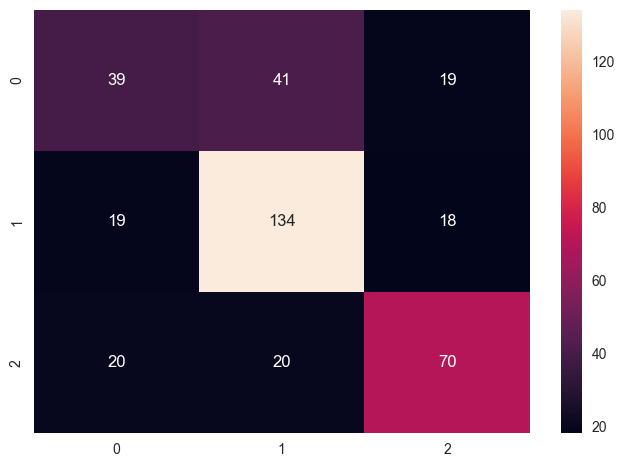

In [150]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt = "d")
plt.show()

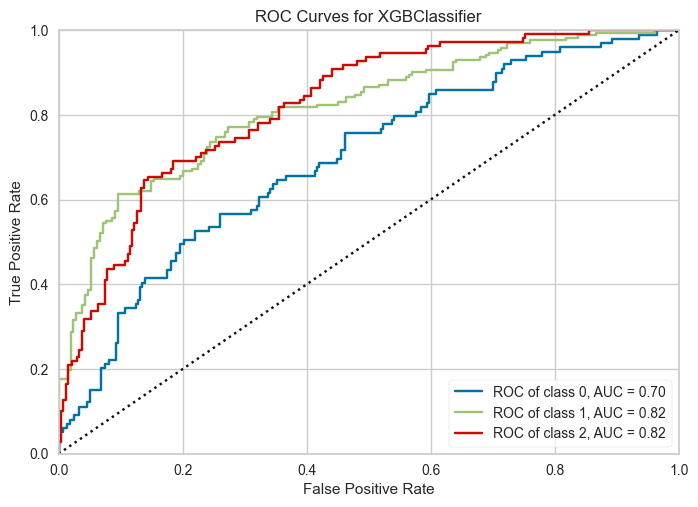

In [151]:
visualizer= ROCAUC(xgb_cls_final, classes=["0", "1", "2"], micro = False, macro=False)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()
plt.show()

In [152]:
# Feature Importances
importance = dict(zip(X_train.columns, xgb_cls_final.feature_importances_))
# summarize feature importance
for i,v in sorted(importance.items(), key = lambda x: x[1], reverse = True):
	print(i, v)

away_shots_on_target 0.012555974
home_shots_on_target 0.011951347
away_captain_name_Lionel Messi 0.009894193
home_captain_name_Jordi Masip 0.009416567
home_team_Huesca 0.009218982
home_captain_name_Javi Moyano 0.00886928
away_team_Barcelona 0.008851142
home_penalty_kicks 0.00823744
away_captain_name_Koke 0.0080682235
referee_name_Santiago Jaime 0.008056995
home_captain_name_Jesús Navas 0.007996127
away_team_Real Madrid 0.007607366
away_penalty_kicks 0.0074621886
venue_name_Estadio El Alcoraz 0.007442135
home_touches_def_pen 0.0070361705
away_team_Levante 0.006738175
away_touches_def_pen 0.006680195
away_team_Atlético Madrid 0.0064033642
away_captain_name_Jordi Masip 0.006311101
home_captain_name_Markel Susaeta 0.006201317
referee_name_Adrián Cordero 0.006184226
away_formation_4-1-2-1-2 0.006148596
away_captain_name_Gabi 0.0060897283
venue_name_Estadio de Mestalla 0.0060638497
referee_name_Isidro Díaz de Mera 0.006025541
away_captain_name_Iago Aspas 0.005987842
away_captain_name_Sergio 

# 2. Gradient Boosting Classifier Final

In [153]:
gbc_final = GradientBoostingClassifier(random_state=5, 
                                 max_depth = 3,
                                learning_rate = 0.07,
                                n_estimators= 250,
                                max_features = 350,
                                min_samples_leaf = 1,
                                min_samples_split = 2)

In [154]:
gbc_final.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.07, max_features=350,
                           n_estimators=250, random_state=5)

In [155]:
y_pred = gbc_final.predict(X_test)

In [156]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.39      0.49      0.44        79
           1       0.77      0.71      0.74       186
           2       0.62      0.59      0.60       115

    accuracy                           0.63       380
   macro avg       0.59      0.60      0.59       380
weighted avg       0.65      0.63      0.64       380



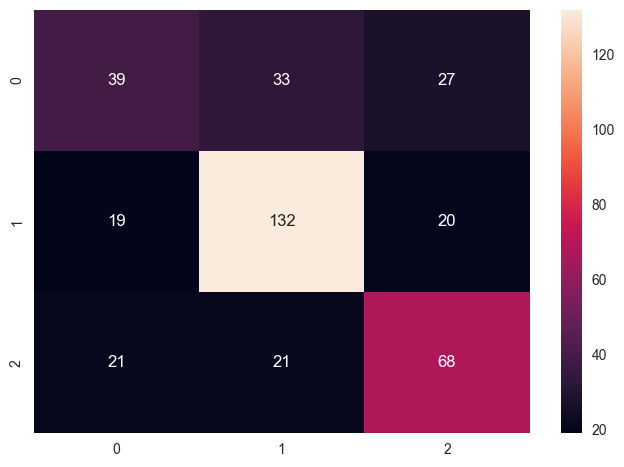

In [157]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt = "d")
plt.show()

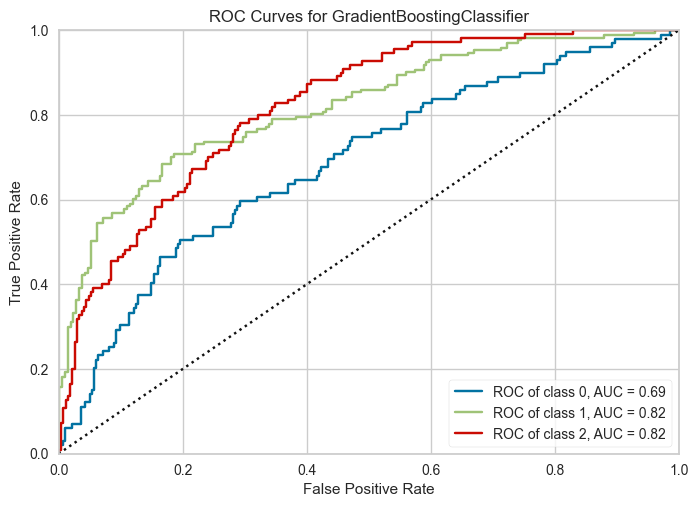

In [158]:
visualizer= ROCAUC(gbc_final, classes=["0", "1", "2"], micro = False, macro=False)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()
plt.show()

In [159]:
# Feature Importances
importance = dict(zip(X_train.columns, gbc_final.feature_importances_))
# summarize feature importance
for i,v in sorted(importance.items(), key = lambda x: x[1], reverse = True):
	print(i, v)

away_shots_on_target 0.1302124930940443
home_shots_on_target 0.12207648866198248
away_touches_def_pen 0.06389399852472617
home_touches_def_pen 0.05037283106243517
away_distance 0.03147472039526097
home_penalty_kicks 0.030176159698647526
away_receiving_rec 0.02758925099295361
away_touches_def_third 0.026175233700122043
away_penalty_kicks 0.025772039291633096
home_distance 0.019015194862099436
home_touches_att_pen 0.01827470820980565
away_touches_att_third 0.01790726111799584
home_touches_def_third 0.01600685852771961
away_touches_att_pen 0.015885181841034525
home_receiving_rec 0.015488190284937007
home_dribbles_mis 0.01527367322080874
away_team_Barcelona 0.014182197879188714
day_of_month 0.012694433180127623
away_touches_mid_third 0.01123816625578545
away_dribbles_success 0.01040767247385547
home_touches_mid_third 0.01032327079468605
home_receiving_prog 0.009619541089647923
away_team_Atlético Madrid 0.009245061691267417
away_touches_live 0.008966812260629382
home_touches_att_third 0.008

## 3. AdaBoost Classifer Final

In [160]:
ada_final = AdaBoostClassifier(random_state=5,
                        n_estimators = 150,
                        learning_rate = 0.065)

In [161]:
ada_final.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.065, n_estimators=150, random_state=5)

In [162]:
y_pred = ada_final.predict(X_test)

In [163]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.30      0.46      0.37        65
           1       0.83      0.62      0.71       229
           2       0.52      0.66      0.58        86

    accuracy                           0.60       380
   macro avg       0.55      0.58      0.55       380
weighted avg       0.67      0.60      0.62       380



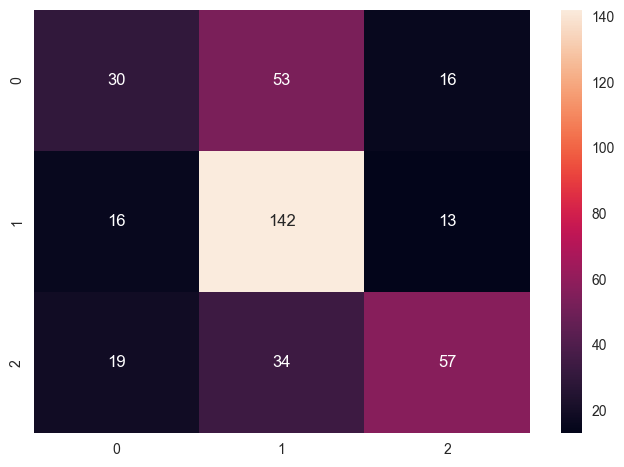

In [164]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt = "d")
plt.show()

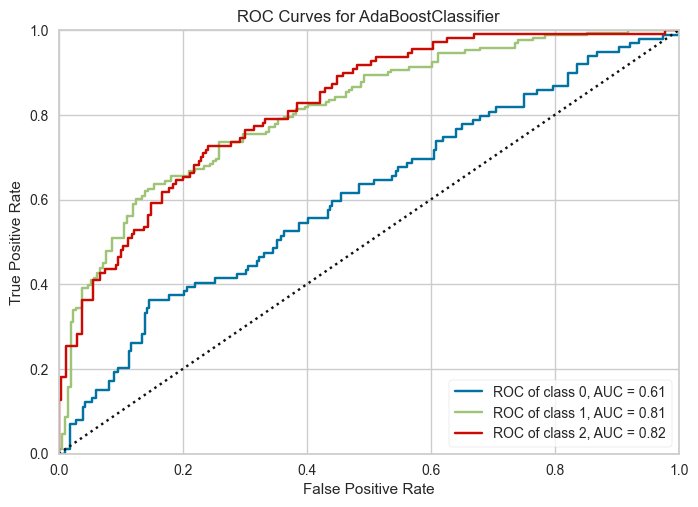

In [165]:
visualizer= ROCAUC(ada_final, classes=["0", "1", "2"], micro = False, macro=False)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()
plt.show()

In [166]:
# Feature Importances
importance = dict(zip(X_train.columns, ada_final.feature_importances_))
# summarize feature importance
for i,v in sorted(importance.items(), key = lambda x: x[1], reverse = True):
	print(i, v)

home_shots_on_target 0.24
away_shots_on_target 0.23333333333333334
away_touches_def_pen 0.13333333333333333
home_touches_def_pen 0.08666666666666667
home_penalty_kicks 0.08
away_penalty_kicks 0.08
away_receiving_rec 0.02
home_team_Atlético Madrid 0.02
away_team_Barcelona 0.02
venue_name_Estadio Wanda Metropolitano 0.02
away_distance 0.013333333333333334
away_team_Atlético Madrid 0.013333333333333334
home_distance 0.006666666666666667
away_touches_def_third 0.006666666666666667
away_dribbles_success 0.006666666666666667
home_team_Barcelona 0.006666666666666667
home_team_Las Palmas 0.006666666666666667
home_team_Real Madrid 0.006666666666666667
home_possession 0.0
away_possession 0.0
home_shots 0.0
home_freekicks 0.0
home_touches 0.0
home_touches_att_pen 0.0
home_touches_def_third 0.0
home_touches_mid_third 0.0
home_touches_att_third 0.0
home_touches_live 0.0
home_dribbles_success 0.0
home_dribbles_att 0.0
home_dribbles_mis 0.0
home_dribbles_dis 0.0
home_receiving_rec 0.0
home_receiving_

## 4. Random Forest Classifier Final

In [167]:
rfc_final = RandomForestClassifier(random_state = 5,
                             criterion = "entropy",
                             max_features = 250,
                             max_depth = 6,
                             min_samples_split = 25,
                             max_leaf_nodes = None,
                             min_samples_leaf = 1,
                             n_jobs = 6)

In [168]:
rfc_final.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=6, max_features=250,
                       min_samples_split=25, n_jobs=6, random_state=5)

In [169]:
y_pred = rfc_final.predict(X_test)

In [170]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.21      0.60      0.31        35
           1       0.84      0.65      0.73       222
           2       0.64      0.57      0.60       123

    accuracy                           0.62       380
   macro avg       0.56      0.61      0.55       380
weighted avg       0.72      0.62      0.65       380



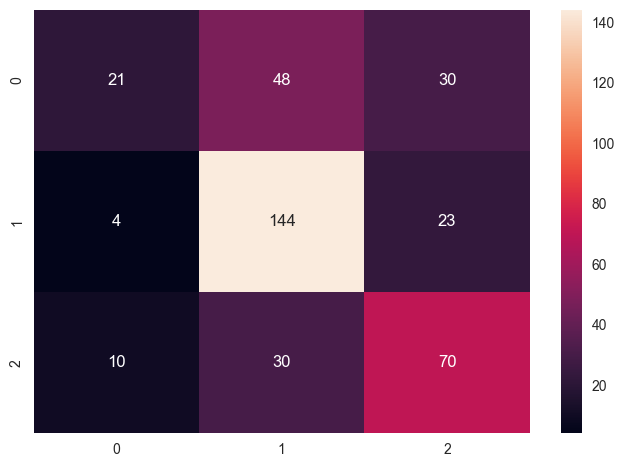

In [171]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt = "d")
plt.show()

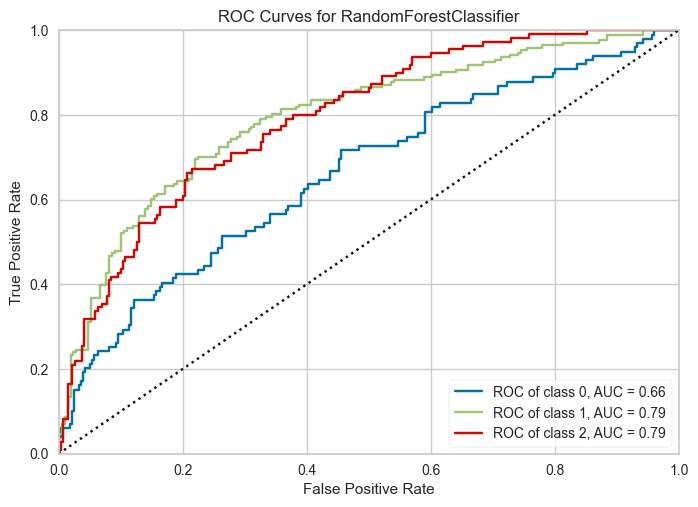

In [172]:
visualizer= ROCAUC(rfc_final, classes=["0", "1", "2"], micro = False, macro=False)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()
plt.show()

In [173]:
# Feature Importances
importance = dict(zip(X_train.columns, rfc_final.feature_importances_))
# summarize feature importance
for i,v in sorted(importance.items(), key = lambda x: x[1], reverse = True):
	print(i, v)

away_shots_on_target 0.18558798520296063
home_shots_on_target 0.16129292480898189
away_touches_def_pen 0.06950372367949426
home_touches_def_pen 0.05884461515582358
away_distance 0.03105808358092905
away_touches_def_third 0.02901854370555474
away_receiving_rec 0.025334818953704374
home_penalty_kicks 0.0233759165912925
home_distance 0.021190017989810423
away_touches_att_pen 0.018792890173400766
home_touches_def_third 0.017232987389314905
home_touches_att_pen 0.01708920146924555
away_penalty_kicks 0.016149111641603556
away_touches_mid_third 0.015373297942199868
home_receiving_rec 0.01410265435911469
away_team_Barcelona 0.013123858297076853
away_touches 0.012800212446674283
away_touches_att_third 0.012213403148857058
home_dribbles_att 0.01220983274490456
day_of_month 0.011825701971794937
home_touches_mid_third 0.011707107241003292
away_dribbles_success 0.010940606938168333
home_receiving_prog 0.010429209269237329
home_touches_att_third 0.01013239428880355
home_dribbles_mis 0.00954280068529

## Predicting El Clasico 2022

In [280]:
# Get The Clasico Record
conn = db.connect()
SQL = """
select
	match_id,
	mf.date_id,
	mf.venue_id,
	mf.referee_id,
	home_team_id as home_id,
	away_team_id as away_id,
	attendance,
    match_week,
	xg_home,
	xg_away,
	home_goal,
	away_goal,
	home_captain_name,
	away_captain_name,
	home_formation,
	away_formation,
	home_possession,
	away_possession,
	home_shots,
	home_shots_on_target,
	home_distance,
	home_freekicks,
	home_penalty_kicks,
	home_touches,
	home_touches_att_pen,
	home_touches_def_pen,
	home_touches_def_third,
	home_touches_mid_third,
	home_touches_att_third,
	home_touches_live,
	home_dribbles_success,
	home_dribbles_att,
	home_dribbles_mis,
	home_dribbles_dis,
	home_receiving_rec,
	home_receiving_prog,
	away_shots,
	away_shots_on_target,
	away_distance,
	away_freekicks,
	away_penalty_kicks,
	away_touches,
	away_touches_att_pen,
	away_touches_def_pen,
	away_touches_def_third,
	away_touches_mid_third,
	away_touches_att_third,
	away_touches_live,
	away_dribbles_success,
	away_dribbles_att,
	away_dribbles_mis,
	away_dribbles_dis,
	away_receiving_rec,
	away_receiving_prog,
	match_result,
	ht.team_name as home_team,
	aw.team_name as away_team,
	md."_date_",
	md."_time_" ,
	md."_day_",
	extract(MONTH from md."_date_") AS month,
	extract(DAY from md."_date_") AS day_of_month,
	extract(DOW from md."_date_") AS day_of_week,
	extract(YEAR from md."_date_") AS year,
	extract(HOUR from md."_time_") AS hour,
	extract(MINUTE from md."_time_") AS minute,
    extract(SECOND from md."_time_") AS second,
	mr.referee_name,
	mv.venue_name
from
	laliga_wh.match_facts mf
inner join laliga_wh.match_teams ht 
on
	ht.team_id = mf.home_team_id
inner join laliga_wh.match_teams aw 
on
	aw.team_id = mf.away_team_id
inner join laliga_wh.match_dates md 
on
	md.date_id = mf.date_id
inner join laliga_wh.match_referees mr 
on
	mr.referee_id = mf.referee_id
inner join laliga_wh.match_venues mv 
on
	mv.venue_id = mf.venue_id
"""
# SQL = """
# select *
# from laliga_wh.match_facts mf 
# where ((home_team_id = 5 and away_team_id = 24)
# or (home_team_id = 24 and away_team_id = 5))
# and date_id = 1819;
# """
clasico_2022 = pd.read_sql(SQL, con=conn)
conn.close()

In [281]:
clasico_2022

,match_id,date_id,venue_id,referee_id,home_id,away_id,attendance,match_week,xg_home,xg_away,...,_day_,month,day_of_month,day_of_week,year,hour,minute,second,referee_name,venue_name
0,1,1,13,23,18,1,9231.0,1,1.3,1.1,...,Fri,8.0,18.0,5.0,2017.0,20.0,15.0,0.0,José Munuera,Estadio Municipal de Butarque
1,2,2,25,19,27,17,35971.0,1,1.4,0.2,...,Fri,8.0,18.0,5.0,2017.0,22.0,15.0,0.0,Jesús Gil,Estadio de Mestalla
2,3,3,22,7,7,25,16961.0,1,1.8,2.1,...,Sat,8.0,19.0,6.0,2017.0,18.0,15.0,0.0,Antonio Matéu Lahoz,Estadio de Balaídos
3,4,4,3,25,13,4,11511.0,1,2.2,0.7,...,Sat,8.0,19.0,6.0,2017.0,20.0,15.0,0.0,Juan Martínez,Estadi Municipal de Montilivi
4,5,5,18,4,26,11,30487.0,1,2.4,1.3,...,Sat,8.0,19.0,6.0,2017.0,22.0,15.0,0.0,Alejandro Hernández,Estadio Ramón Sánchez Pizjuán
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005,2006,1837,5,19,6,4,50179.0,11,1.5,0.7,...,Sun,10.0,23.0,0.0,2022.0,16.0,15.0,0.0,Jesús Gil,Estadio Benito Villamarín
2006,2007,1838,3,26,13,22,10032.0,11,0.4,0.6,...,Sun,10.0,23.0,0.0,2022.0,18.0,30.0,0.0,Juan Pulido,Estadi Municipal de Montilivi
2007,2008,1838,6,30,29,2,13816.0,11,1.0,1.0,...,Sun,10.0,23.0,0.0,2022.0,18.0,30.0,0.0,Ricardo de Burgos,Estadio Ciudad de Valencia
2008,2009,1839,1,25,5,3,84817.0,11,1.5,0.4,...,Sun,10.0,23.0,0.0,2022.0,21.0,0.0,0.0,Juan Martínez,Camp Nou


In [282]:
# Drop id columns
clasico_2022 = clasico_2022.iloc[:,6:]
clasico_2022

,attendance,match_week,xg_home,xg_away,home_goal,away_goal,home_captain_name,away_captain_name,home_formation,away_formation,...,_day_,month,day_of_month,day_of_week,year,hour,minute,second,referee_name,venue_name
0,9231.0,1,1.3,1.1,1,0,Martín Mantovani,Manu García,4-2-3-1,4-4-2,...,Fri,8.0,18.0,5.0,2017.0,20.0,15.0,0.0,José Munuera,Estadio Municipal de Butarque
1,35971.0,1,1.4,0.2,1,0,Daniel Parejo,Jonathan Viera,4-4-2,4-1-4-1,...,Fri,8.0,18.0,5.0,2017.0,22.0,15.0,0.0,Jesús Gil,Estadio de Mestalla
2,16961.0,1,1.8,2.1,2,3,Hugo Mallo,Xabi Prieto,4-3-3,4-3-3,...,Sat,8.0,19.0,6.0,2017.0,18.0,15.0,0.0,Antonio Matéu Lahoz,Estadio de Balaídos
3,11511.0,1,2.2,0.7,2,2,Álex Granell,Gabi,3-4-3,4-4-2,...,Sat,8.0,19.0,6.0,2017.0,20.0,15.0,0.0,Juan Martínez,Estadi Municipal de Montilivi
4,30487.0,1,2.4,1.3,1,1,Jesús Navas,Gerard Moreno,4-1-4-1,4-4-2,...,Sat,8.0,19.0,6.0,2017.0,22.0,15.0,0.0,Alejandro Hernández,Estadio Ramón Sánchez Pizjuán
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005,50179.0,11,1.5,0.7,1,2,Andrés Guardado,Jan Oblak,4-2-3-1,4-4-2,...,Sun,10.0,23.0,0.0,2022.0,16.0,15.0,0.0,Jesús Gil,Estadio Benito Villamarín
2006,10032.0,11,0.4,0.6,1,1,Aleix García,Unai García,4-4-1-1,4-1-4-1,...,Sun,10.0,23.0,0.0,2022.0,18.0,30.0,0.0,Juan Pulido,Estadi Municipal de Montilivi
2007,13816.0,11,1.0,1.0,2,1,Raúl Albiol,Lucas Robertone,4-2-3-1,5-3-2,...,Sun,10.0,23.0,0.0,2022.0,18.0,30.0,0.0,Ricardo de Burgos,Estadio Ciudad de Valencia
2008,84817.0,11,1.5,0.4,4,0,Sergio Busquets,Óscar de Marcos,4-3-3,4-2-3-1,...,Sun,10.0,23.0,0.0,2022.0,21.0,0.0,0.0,Juan Martínez,Camp Nou


In [283]:
# Fix data types for certain columns
clasico_2022['attendance'] = clasico_2022['attendance'].astype(pd.Int64Dtype())
clasico_2022['_date_'] = pd.to_datetime(clasico_2022['_date_'])
# int_columns = clasico_2022.select_dtypes(include=['Int64', 'int64']).columns
# float_columns = clasico_2022.select_dtypes(include=['float64']).columns
# clasico_2022[int_columns] = clasico_2022[int_columns].astype('int64')
# clasico_2022[float_columns] = clasico_2022[float_columns].astype('np.float32')
clasico_2022['month'] = clasico_2022['month'].astype('int64')
clasico_2022['day_of_month'] = clasico_2022['day_of_month'].astype('int64')
clasico_2022['day_of_week'] = clasico_2022['day_of_week'].astype('int64')
clasico_2022['year'] = clasico_2022['year'].astype('int64')
clasico_2022['hour'] = clasico_2022['hour'].astype('int64')
clasico_2022['minute'] = clasico_2022['minute'].astype('int64')
clasico_2022['second'] = clasico_2022['second'].astype('int64')
clasico_2022.drop(['_day_', '_time_'], axis = 1, inplace = True) # Not needed as we created numerical columns for the date components

In [284]:
# Clean up formations
clasico_2022['home_formation'] = clasico_2022['home_formation'].replace({'4-4-2◆': '4-4-2', '4-3-1-2◆':'4-3-1-2', '4-3-3◆':'4-3-3', '4-1-3-2◆':'4-1-3-2',
                                         '4-2-3-1◆':'4-2-3-1', '3-4-3◆':'3-4-3', '4-1-2-1-2◆': '4-1-2-1-2'})
clasico_2022['away_formation'] = clasico_2022['away_formation'].replace({'4-4-2◆': '4-4-2', '4-3-1-2◆':'4-3-1-2', '4-3-3◆':'4-3-3', '4-1-3-2◆':'4-1-3-2',
                                         '4-2-3-1◆':'4-2-3-1', '3-4-3◆':'3-4-3', '4-3-2-1◆':'4-3-2-1', '4-1-2-1-2◆': '4-1-2-1-2'})

In [285]:
# Count number of missing values
for i, v in clasico_2022.isna().sum().iteritems():
    print(i + '\t' + str(v))

attendance	489
match_week	0
xg_home	0
xg_away	0
home_goal	0
away_goal	0
home_captain_name	0
away_captain_name	0
home_formation	0
away_formation	0
home_possession	0
away_possession	0
home_shots	0
home_shots_on_target	0
home_distance	0
home_freekicks	0
home_penalty_kicks	0
home_touches	0
home_touches_att_pen	0
home_touches_def_pen	0
home_touches_def_third	0
home_touches_mid_third	0
home_touches_att_third	0
home_touches_live	0
home_dribbles_success	0
home_dribbles_att	0
home_dribbles_mis	0
home_dribbles_dis	0
home_receiving_rec	0
home_receiving_prog	0
away_shots	0
away_shots_on_target	0
away_distance	2
away_freekicks	0
away_penalty_kicks	0
away_touches	0
away_touches_att_pen	0
away_touches_def_pen	0
away_touches_def_third	0
away_touches_mid_third	0
away_touches_att_third	0
away_touches_live	0
away_dribbles_success	0
away_dribbles_att	0
away_dribbles_mis	0
away_dribbles_dis	0
away_receiving_rec	0
away_receiving_prog	0
match_result	0
home_team	0
away_team	0
_date_	0
month	0
day_of_month	0
d

In [286]:
clasico_2022

,attendance,match_week,xg_home,xg_away,home_goal,away_goal,home_captain_name,away_captain_name,home_formation,away_formation,...,_date_,month,day_of_month,day_of_week,year,hour,minute,second,referee_name,venue_name
0,9231,1,1.3,1.1,1,0,Martín Mantovani,Manu García,4-2-3-1,4-4-2,...,2017-08-18,8,18,5,2017,20,15,0,José Munuera,Estadio Municipal de Butarque
1,35971,1,1.4,0.2,1,0,Daniel Parejo,Jonathan Viera,4-4-2,4-1-4-1,...,2017-08-18,8,18,5,2017,22,15,0,Jesús Gil,Estadio de Mestalla
2,16961,1,1.8,2.1,2,3,Hugo Mallo,Xabi Prieto,4-3-3,4-3-3,...,2017-08-19,8,19,6,2017,18,15,0,Antonio Matéu Lahoz,Estadio de Balaídos
3,11511,1,2.2,0.7,2,2,Álex Granell,Gabi,3-4-3,4-4-2,...,2017-08-19,8,19,6,2017,20,15,0,Juan Martínez,Estadi Municipal de Montilivi
4,30487,1,2.4,1.3,1,1,Jesús Navas,Gerard Moreno,4-1-4-1,4-4-2,...,2017-08-19,8,19,6,2017,22,15,0,Alejandro Hernández,Estadio Ramón Sánchez Pizjuán
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005,50179,11,1.5,0.7,1,2,Andrés Guardado,Jan Oblak,4-2-3-1,4-4-2,...,2022-10-23,10,23,0,2022,16,15,0,Jesús Gil,Estadio Benito Villamarín
2006,10032,11,0.4,0.6,1,1,Aleix García,Unai García,4-4-1-1,4-1-4-1,...,2022-10-23,10,23,0,2022,18,30,0,Juan Pulido,Estadi Municipal de Montilivi
2007,13816,11,1.0,1.0,2,1,Raúl Albiol,Lucas Robertone,4-2-3-1,5-3-2,...,2022-10-23,10,23,0,2022,18,30,0,Ricardo de Burgos,Estadio Ciudad de Valencia
2008,84817,11,1.5,0.4,4,0,Sergio Busquets,Óscar de Marcos,4-3-3,4-2-3-1,...,2022-10-23,10,23,0,2022,21,0,0,Juan Martínez,Camp Nou


In [287]:
for i, v in clasico_2022.isna().sum().iteritems():
    print(i + '\t' + str(v))

attendance	489
match_week	0
xg_home	0
xg_away	0
home_goal	0
away_goal	0
home_captain_name	0
away_captain_name	0
home_formation	0
away_formation	0
home_possession	0
away_possession	0
home_shots	0
home_shots_on_target	0
home_distance	0
home_freekicks	0
home_penalty_kicks	0
home_touches	0
home_touches_att_pen	0
home_touches_def_pen	0
home_touches_def_third	0
home_touches_mid_third	0
home_touches_att_third	0
home_touches_live	0
home_dribbles_success	0
home_dribbles_att	0
home_dribbles_mis	0
home_dribbles_dis	0
home_receiving_rec	0
home_receiving_prog	0
away_shots	0
away_shots_on_target	0
away_distance	2
away_freekicks	0
away_penalty_kicks	0
away_touches	0
away_touches_att_pen	0
away_touches_def_pen	0
away_touches_def_third	0
away_touches_mid_third	0
away_touches_att_third	0
away_touches_live	0
away_dribbles_success	0
away_dribbles_att	0
away_dribbles_mis	0
away_dribbles_dis	0
away_receiving_rec	0
away_receiving_prog	0
match_result	0
home_team	0
away_team	0
_date_	0
month	0
day_of_month	0
d

In [288]:
clasico_2022_encode.head()

,attendance,match_week,xg_home,xg_away,home_goal,away_goal,home_possession,away_possession,home_shots,home_shots_on_target,...,venue_name_Estadio de Balaídos,venue_name_Estadio de Gran Canaria,venue_name_Estadio de Mendizorroza,venue_name_Estadio de Mestalla,venue_name_Estadio de la Cerámica,venue_name_Estadio de los Juegos Mediterráneos,venue_name_Estadio del Rayo Vallecano,venue_name_Iberostar Estadi,venue_name_RCDE Stadium,venue_name_San Mamés
1900,18536,1,1.5,0.9,2,1,35.0,65.0,11,4,...,0,0,0,0,0,0,0,0,0,0
1901,13859,1,0.4,1.1,2,2,60.0,40.0,8,3,...,1,0,0,0,0,0,0,0,0,0
1902,17543,1,1.0,1.5,0,3,51.0,49.0,12,6,...,0,0,0,0,0,0,0,0,0,0
1903,81104,1,1.9,0.5,0,0,67.0,33.0,21,5,...,0,0,0,0,0,0,0,0,0,0
1904,16570,1,0.2,1.5,0,1,41.0,59.0,7,1,...,0,0,0,0,0,0,0,0,0,0


In [289]:
clasico_2022_encode.columns

Index(['attendance', 'match_week', 'xg_home', 'xg_away', 'home_goal',
       'away_goal', 'home_possession', 'away_possession', 'home_shots',
       'home_shots_on_target',
       ...
       'venue_name_Estadio de Balaídos', 'venue_name_Estadio de Gran Canaria',
       'venue_name_Estadio de Mendizorroza', 'venue_name_Estadio de Mestalla',
       'venue_name_Estadio de la Cerámica',
       'venue_name_Estadio de los Juegos Mediterráneos',
       'venue_name_Estadio del Rayo Vallecano', 'venue_name_Iberostar Estadi',
       'venue_name_RCDE Stadium', 'venue_name_San Mamés'],
      dtype='object', length=577)

In [290]:
# One hot encode
clasico_2022_encode = pd.get_dummies(clasico_2022, columns = ['home_captain_name', 'away_captain_name', 'home_formation', 'away_formation',
                                                                'home_team', 'away_team', 'referee_name', 'venue_name'])

In [291]:
# Get test_data
start_date = '2022-06-01'
mask = (clasico_2022_encode['_date_'] > start_date) 
clasico_2022_encode = clasico_2022_encode.loc[mask]

In [292]:
# # Drop attendance. We have MCAR data here and not recommended to keep it
# # Drop _date_. We already split this into numerical components
# # Fill other columns with 1 or 2 missing values with median
# clasico_2022_encode.drop(['attendance', '_date_', 'match_week'], axis = 1, inplace = True)
# clasico_2022_encode[ 'away_distance'] = clasico_2022_encode[ 'away_distance'].fillna(clasico_2022['away_distance'].median())
# int_columns = clasico_2022_encode.select_dtypes(include=['Int64', 'int64']).columns
# clasico_2022_encode[int_columns] = clasico_2022_encode[int_columns].astype('int64')

In [293]:
clasico_2022_encode


,attendance,match_week,xg_home,xg_away,home_goal,away_goal,home_possession,away_possession,home_shots,home_shots_on_target,...,venue_name_Estadio de Balaídos,venue_name_Estadio de Gran Canaria,venue_name_Estadio de Mendizorroza,venue_name_Estadio de Mestalla,venue_name_Estadio de la Cerámica,venue_name_Estadio de los Juegos Mediterráneos,venue_name_Estadio del Rayo Vallecano,venue_name_Iberostar Estadi,venue_name_RCDE Stadium,venue_name_San Mamés
1900,18536,1,1.5,0.9,2,1,35.0,65.0,11,4,...,0,0,0,0,0,0,0,0,0,0
1901,13859,1,0.4,1.1,2,2,60.0,40.0,8,3,...,1,0,0,0,0,0,0,0,0,0
1902,17543,1,1.0,1.5,0,3,51.0,49.0,12,6,...,0,0,0,0,0,0,0,0,0,0
1903,81104,1,1.9,0.5,0,0,67.0,33.0,21,5,...,0,0,0,0,0,0,0,0,0,0
1904,16570,1,0.2,1.5,0,1,41.0,59.0,7,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005,50179,11,1.5,0.7,1,2,55.0,45.0,17,4,...,0,0,0,0,0,0,0,0,0,0
2006,10032,11,0.4,0.6,1,1,50.0,50.0,7,1,...,0,0,0,0,0,0,0,0,0,0
2007,13816,11,1.0,1.0,2,1,52.0,48.0,11,5,...,0,0,0,0,0,0,0,0,0,0
2008,84817,11,1.5,0.4,4,0,65.0,35.0,10,7,...,0,0,0,0,0,0,0,0,0,0


In [294]:
clasico_2022_encode[(clasico_2022_encode['_date_'] == '2022-10-16') & (clasico_2022_encode['venue_name_Estadio Santiago Bernabéu'] == 1)]

,attendance,match_week,xg_home,xg_away,home_goal,away_goal,home_possession,away_possession,home_shots,home_shots_on_target,...,venue_name_Estadio de Balaídos,venue_name_Estadio de Gran Canaria,venue_name_Estadio de Mendizorroza,venue_name_Estadio de Mestalla,venue_name_Estadio de la Cerámica,venue_name_Estadio de los Juegos Mediterráneos,venue_name_Estadio del Rayo Vallecano,venue_name_Iberostar Estadi,venue_name_RCDE Stadium,venue_name_San Mamés
1986,62876,9,1.4,2.1,3,1,44.0,56.0,7,3,...,0,0,0,0,0,0,0,0,0,0


In [295]:
clasico_match_2022 = clasico_2022_encode[(clasico_2022_encode['_date_'] == '2022-10-16') & (clasico_2022_encode['venue_name_Estadio Santiago Bernabéu'] == 1)]

In [296]:
# Filter for same columns as model
X = clasico_match_2022[X_train.columns]
y = clasico_match_2022['match_result']

In [297]:
X

,home_possession,away_possession,home_shots,home_shots_on_target,home_distance,home_freekicks,home_penalty_kicks,home_touches,home_touches_att_pen,home_touches_def_pen,...,venue_name_Estadio Wanda Metropolitano,venue_name_Estadio de Balaídos,venue_name_Estadio de Gran Canaria,venue_name_Estadio de Mendizorroza,venue_name_Estadio de Mestalla,venue_name_Estadio de la Cerámica,venue_name_Estadio del Rayo Vallecano,venue_name_Iberostar Estadi,venue_name_RCDE Stadium,venue_name_San Mamés
1986,44.0,56.0,7,3,18.6,0,1,539,17,76,...,0,0,0,0,0,0,0,0,0,0


In [298]:
y

1986    HW
Name: match_result, dtype: object

In [299]:
#Have to map this for xgboost
y = y.map({"D" : 0, "HW": 1, "AW":2})

In [304]:
y

1986    1
Name: match_result, dtype: int64

In [301]:
# Use the XGBoostModel
xgb_cls_final.predict(X)[0]

1